In [2]:
import gc
import glob
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
import warnings

import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from joblib import Parallel, delayed
from tqdm import tqdm, tqdm_notebook
from sklearn.model_selection import GridSearchCV
import os

from sklearn.metrics import r2_score


# part 2
# required packages

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC

from textblob import TextBlob


%matplotlib inline

np.random.seed(seed=555)
warnings.filterwarnings('ignore')



In [3]:

# Load data
train = pd.read_csv('input/train/train.csv')
test = pd.read_csv('input/test/test.csv')
breed_labels = pd.read_csv('input/breed_labels.csv')
color_labels = pd.read_csv('input/color_labels.csv')
state_labels = pd.read_csv('input/state_labels.csv')


In [5]:
train.head()

Type         Name  Age  Breed1  Breed2  Gender  Color1  Color2  Color3  \
0     2       Nibble    3     299       0       1       1       7       0   
1     2  No Name Yet    1     265       0       1       1       2       0   
2     1       Brisco    1     307       0       1       2       7       0   
3     1         Miko    4     307       0       2       1       2       0   
4     1       Hunter    1     307       0       1       1       0       0   

   MaturitySize  ...  Health  Quantity  Fee  State  \
0             1  ...       1         1  100  41326   
1             2  ...       1         1    0  41401   
2             2  ...       1         1    0  41326   
3             2  ...       1         1  150  41401   
4             2  ...       1         1    0  41326   

                          RescuerID  VideoAmt  \
0  8480853f516546f6cf33aa88cd76c379         0   
1  3082c7125d8fb66f7dd4bff4192c8b14         0   
2  fa90fa5b1ee11c86938398b60abc32cb         0   
3  9238e4f44c71a75282e62f7136c6b240         0   
4  95481e953f8aed9ec3d16fc4509537e8         0   

                                         Description      PetID PhotoAmt  \
0  Nibble is a 3+ month old ball of cuteness. He ...  86e1089a3      1.0   
1  I just found it alone yesterday near my apartm...  6296e909a      2.0   
2  Their pregnant mother was dumped by her irresp...  3422e4906      7.0   
3  Good guard dog, very alert, active, obedience ...  5842f1ff5      8.0   
4  This handsome yet cute boy is up for adoption....  850a43f90      3.0   

   AdoptionSpeed  
0              2  
1              0  
2              3  
3              2  
4              2  

[5 rows x 24 columns]

In [265]:
# Display basic information about the data
train.info()

# Check for missing values
train.isnull().sum()

# Descriptive statistics
train.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Type           14993 non-null  int64  
 1   Name           13728 non-null  object 
 2   Age            14993 non-null  int64  
 3   Breed1         14993 non-null  int64  
 4   Breed2         14993 non-null  int64  
 5   Gender         14993 non-null  int64  
 6   Color1         14993 non-null  int64  
 7   Color2         14993 non-null  int64  
 8   Color3         14993 non-null  int64  
 9   MaturitySize   14993 non-null  int64  
 10  FurLength      14993 non-null  int64  
 11  Vaccinated     14993 non-null  int64  
 12  Dewormed       14993 non-null  int64  
 13  Sterilized     14993 non-null  int64  
 14  Health         14993 non-null  int64  
 15  Quantity       14993 non-null  int64  
 16  Fee            14993 non-null  int64  
 17  State          14993 non-null  int64  
 18  Rescue

Type           Age        Breed1        Breed2        Gender  \
count  14993.000000  14993.000000  14993.000000  14993.000000  14993.000000   
mean       1.457614     10.452078    265.272594     74.009738      1.776162   
std        0.498217     18.155790     60.056818    123.011575      0.681592   
min        1.000000      0.000000      0.000000      0.000000      1.000000   
25%        1.000000      2.000000    265.000000      0.000000      1.000000   
50%        1.000000      3.000000    266.000000      0.000000      2.000000   
75%        2.000000     12.000000    307.000000    179.000000      2.000000   
max        2.000000    255.000000    307.000000    307.000000      3.000000   

             Color1        Color2        Color3  MaturitySize     FurLength  \
count  14993.000000  14993.000000  14993.000000  14993.000000  14993.000000   
mean       2.234176      3.222837      1.882012      1.862002      1.467485   
std        1.745225      2.742562      2.984086      0.547959      0.599070   
min        1.000000      0.000000      0.000000      1.000000      1.000000   
25%        1.000000      0.000000      0.000000      2.000000      1.000000   
50%        2.000000      2.000000      0.000000      2.000000      1.000000   
75%        3.000000      6.000000      5.000000      2.000000      2.000000   
max        7.000000      7.000000      7.000000      4.000000      3.000000   

         Vaccinated      Dewormed    Sterilized        Health      Quantity  \
count  14993.000000  14993.000000  14993.000000  14993.000000  14993.000000   
mean       1.731208      1.558727      1.914227      1.036617      1.576069   
std        0.667649      0.695817      0.566172      0.199535      1.472477   
min        1.000000      1.000000      1.000000      1.000000      1.000000   
25%        1.000000      1.000000      2.000000      1.000000      1.000000   
50%        2.000000      1.000000      2.000000      1.000000      1.000000   
75%        2.000000      2.000000      2.000000      1.000000      1.000000   
max        3.000000      3.000000      3.000000      3.000000     20.000000   

                Fee         State      VideoAmt      PhotoAmt  AdoptionSpeed  
count  14993.000000  14993.000000  14993.000000  14993.000000   14993.000000  
mean      21.259988  41346.028347      0.056760      3.889215       2.516441  
std       78.414548     32.444153      0.346185      3.487810       1.177265  
min        0.000000  41324.000000      0.000000      0.000000       0.000000  
25%        0.000000  41326.000000      0.000000      2.000000       2.000000  
50%        0.000000  41326.000000      0.000000      3.000000       2.000000  
75%        0.000000  41401.000000      0.000000      5.000000       4.000000  
max     3000.000000  41415.000000      8.000000     30.000000       4.000000

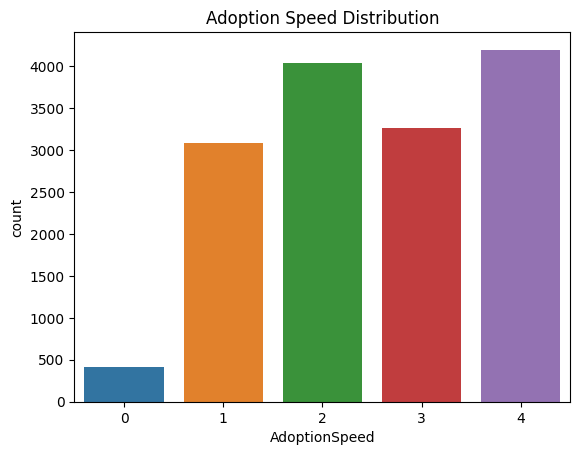

In [266]:
# Visualize AdoptionSpeed distribution
sns.countplot(x='AdoptionSpeed', data=train)
plt.title('Adoption Speed Distribution')
plt.show()

## Age

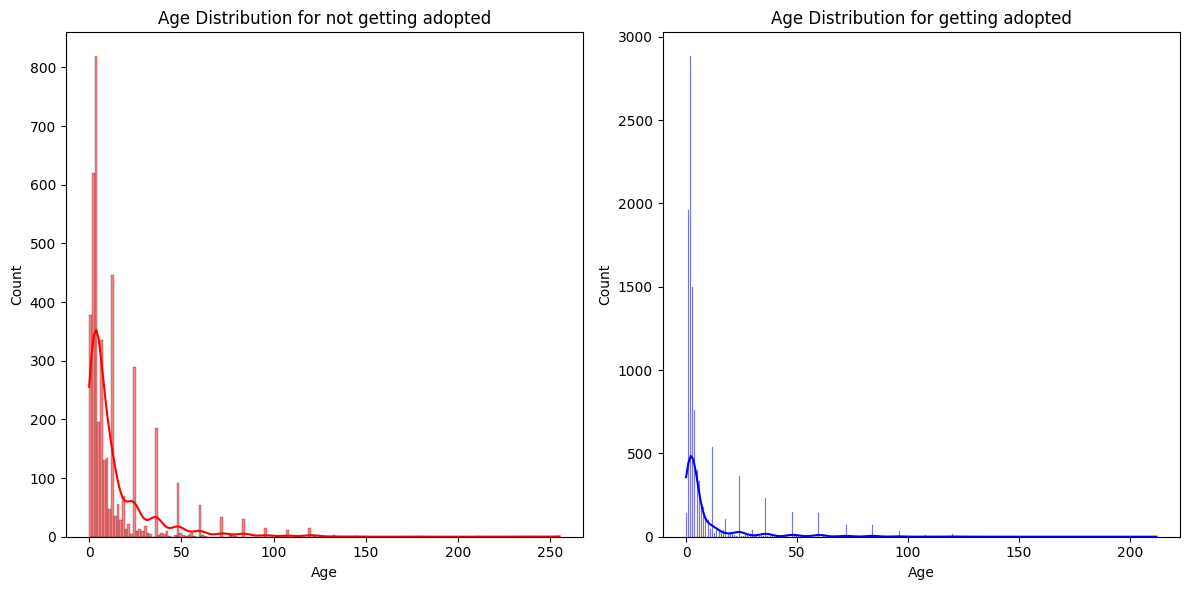

In [46]:
data = train.copy()

data_4 = data[data['AdoptionSpeed']==4]
data_rest = data[data['AdoptionSpeed']<4]
# Create subplots
plt.figure(figsize=(12, 6))
# Plot age distribution for fraud cases
plt.subplot(1, 2, 1)
sns.histplot(data=data_4, x='Age', kde=True, color='red')
plt.title("Age Distribution for not getting adopted")

# Plot age distribution for non-fraud cases
plt.subplot(1, 2, 2)
sns.histplot(data=data_rest, x='Age', kde=True, color='blue')
plt.title("Age Distribution for getting adopted")

# Show the plots
plt.tight_layout()
plt.show()

In [48]:
len(data_4), len(data_rest)

(4197, 10796)

In [32]:
len(unique_categories), len(encoded_labels)

(106, 14993)

In [36]:
def age_segment(df):

    # Creating the "age_group" column by binning them into 4 groups
    conditions = [
        df['Age'] < 20,
        (df['Age'] >= 20) & (df['Age'] <= 40),
        (df['Age'] >= 40) & (df['Age'] <= 60),
        (df['Age'] >= 60) & (df['Age'] <= 80),
        (df['Age'] >= 80) & (df['Age'] <= 100)
    ]
    choices = ['1-20', '20-40', '40-60', '60-80','80-100']
    df['AgeGroup'] = np.select(conditions, choices, default='Unknown')
    
    return df


In [38]:
data = train.copy()

data = age_segment(data)
# encoded_labels, unique_categories = pd.factorize(data['Age'])
# len(unique_categories), len(encoded_labels)
data['AgeGroup']

0         1-20
1         1-20
2         1-20
3         1-20
4         1-20
         ...  
14988     1-20
14989    40-60
14990     1-20
14991     1-20
14992     1-20
Name: AgeGroup, Length: 14993, dtype: object

In [41]:
data['Age']

0         3
1         1
2         1
3         4
4         1
         ..
14988     2
14989    60
14990     2
14991     9
14992     1
Name: Age, Length: 14993, dtype: int64

In [44]:
import pandas as pd

# Assuming you have a DataFrame named 'data' with a column 'Age'
# Replace 'data' and 'Age' with your actual DataFrame and column names
data = train.copy()
# Define the bin edges and labels
bin_edges = [0, 5, 10, 20, 40, 100]  # Adjust the bin edges as needed
# bin_edges = [0, 20, 40, 60, 80, 100]  # Adjust the bin edges as needed

bin_labels = ['Group 1', 'Group 2', 'Group 3', 'Group 4', 'Group 5']

# Bin the 'Age' column
data['AgeGroup'] = pd.cut(data['Age'], bins=bin_edges, labels=bin_labels, include_lowest=True)

# Print the resulting DataFrame
print(data['AgeGroup'])


0        Group 1
1        Group 1
2        Group 1
3        Group 1
4        Group 1
          ...   
14988    Group 1
14989    Group 5
14990    Group 1
14991    Group 2
14992    Group 1
Name: AgeGroup, Length: 14993, dtype: category
Categories (5, object): ['Group 1' < 'Group 2' < 'Group 3' < 'Group 4' < 'Group 5']


In [267]:
# Handle missing values (e.g., fill with median)
# train['Age'].fillna(train['Age'].median(), inplace=True)


In [111]:
# Create a new feature based on the length of the description
train['Description_Length'] = train['Description'].apply(lambda x: len(str(x)))

# Create a feature indicating whether a pet has a name or not
train['HasName'] = train['Name'].apply(lambda x: 0 if pd.isnull(x) else 1)


In [3]:
def get_polarity(text):
    return TextBlob(text).sentiment.polarity

def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

In [26]:
!pip install TextBlob


Defaulting to user installation because normal site-packages is not writeable
                                              0.0/636.8 kB ? eta -:--:--
     -----------------------                389.1/636.8 kB 8.1 MB/s eta 0:00:01
     -------------------------------------- 636.8/636.8 kB 8.0 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [27]:
from textblob import TextBlob
train['polarity'] = train['Description'].astype(str).apply(get_polarity)
train['subjectivity'] = train['Description'].astype(str).apply(get_subjectivity)

test['polarity'] = test['Description'].astype(str).apply(get_polarity)
test['subjectivity'] = test['Description'].astype(str).apply(get_subjectivity)


In [28]:
print(train[['Description', 'polarity', 'subjectivity']].head())
print(test[['Description', 'polarity', 'subjectivity']].head())


                                         Description  polarity  subjectivity
0  Nibble is a 3+ month old ball of cuteness. He ...  0.130357      0.407143
1  I just found it alone yesterday near my apartm...  0.100000      0.400000
2  Their pregnant mother was dumped by her irresp...  0.261905      0.542857
3  Good guard dog, very alert, active, obedience ...  0.341146      0.437500
4  This handsome yet cute boy is up for adoption....  0.400000      0.743750
                                         Description  polarity  subjectivity
0  Dopey Age: 8mths old Male One half of a pair, ...  0.035937      0.230729
1  Please note that Chichi has been neutered, the...  0.054464      0.167445
2  Sticky, named such because of his tendency to ...  0.317857      0.678571
3  Dannie and Kass are mother and daughter. We en...  0.347865      0.603333
4  Extremely cuddly cat, hence the origin of his ...  0.142347      0.657143


In [4]:
# img mahmood feat.
import numpy as np # linear algebra
import pandas as pd
pd.set_option('display.max_rows', None)  # Display all rows
pd.set_option('display.max_columns', None)  # Display all columns
import json
import cv2
import numpy as np
import skimage.feature as skf
import skimage.filters as skg
from skimage.measure import shannon_entropy
from scipy.stats import entropy
from sklearn.cluster import KMeans


In [5]:
def extract_texture_features(image_path):
    # Load the image
    img = cv2.imread(image_path)

    # Convert the image to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    haralick = skf.graycomatrix(img_gray, [1], [0], 256, symmetric=True, normed=True) 
    energy = skf.graycoprops(haralick, 'energy')[0, 0] 
    contrast = skf.graycoprops(haralick, 'contrast')[0, 0] 
    correlation = skf.graycoprops(haralick, 'correlation')[0, 0] 
    entropy = shannon_entropy(img_gray)

    mean = np.mean(img)
    std_dev = np.std(img)

    return energy, contrast, correlation, entropy, mean, std_dev


In [1]:
df_train_img = pd.DataFrame(columns=['PetID', 'Energy', 'Contrast', 'Correlation', 'Entropy', 'Mean', 'Std_Dev'])
train_img_path = 'input/train_images'
# Loop through each image in the folder
for filename in os.listdir(train_img_path):
    if filename.endswith('.jpg'):
        # Extract the texture features
        energy, contrast, correlation, entropy, mean, std_dev = extract_texture_features(os.path.join(train_img_path, filename))
        
        # Add the features to the dataframe
        df_train_img = pd.concat([df_train_img, pd.DataFrame({'PetID': [filename[:-4]], 'Energy': [energy], 'Contrast': [contrast], 'Correlation': [correlation], 'Entropy': [entropy], 'Mean': [mean], 'Std_Dev': [std_dev]})])
        
# df_train_img.to_csv('df_train_img_texture.csv')



In [96]:
df_train_img.head()

PetID    Energy    Contrast  Correlation   Entropy        Mean  \
0  0008c5398-1  0.024081   78.820303     0.989859  7.601080  143.223922   
0  0008c5398-2  0.070913   41.355089     0.994805  7.284530   91.658592   
0  0008c5398-3  0.040957   66.469614     0.989986  7.594550  111.068160   
0  0008c5398-4  0.050778  150.613044     0.984973  7.517500  108.980235   
0  0008c5398-5  0.025575   79.317245     0.992683  7.719211  141.169160   

     Std_Dev  
0  70.638848  
0  64.059420  
0  73.856578  
0  71.533391  
0  76.906123

In [97]:
def extract_keypoints(file_path):
    # Load an image
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

    # Initialize the SIFT detector
    sift = cv2.SIFT_create()

    # Detect and compute SIFT keypoints and descriptors
    keypoints, _ = sift.detectAndCompute(image, None)

    # Return the number of keypoints
    return len(keypoints)


df_train_img['num_checkpoints'] = None  # Initialize the column

def extract_and_update(row):
    file_path = os.path.join(train_img_path, f"{row['PetID']}.jpg")
    num_keypoints = extract_keypoints(file_path)
    return num_keypoints


# Update the 'num_checkpoints' column
df_train_img['num_checkpoints'] = df_train_img.apply(extract_and_update, axis=1)
# df_train_img.to_csv('train_img_keypoints.csv')



In [98]:
# Columns to drop
columns_to_drop = ['mean_h', 'mean_s', 'mean_v', 'variance_h', 'variance_s', 'variance_v', 'Unnamed: 0']

# Drop specified columns
final_keypoints = df_train_img.drop(columns=columns_to_drop, errors='ignore')

# Print the resulting DataFrame
final_keypoints.head()


PetID    Energy    Contrast  Correlation   Entropy        Mean  \
0  0008c5398-1  0.024081   78.820303     0.989859  7.601080  143.223922   
0  0008c5398-2  0.070913   41.355089     0.994805  7.284530   91.658592   
0  0008c5398-3  0.040957   66.469614     0.989986  7.594550  111.068160   
0  0008c5398-4  0.050778  150.613044     0.984973  7.517500  108.980235   
0  0008c5398-5  0.025575   79.317245     0.992683  7.719211  141.169160   

     Std_Dev  num_checkpoints  
0  70.638848              319  
0  64.059420              233  
0  73.856578              410  
0  71.533391              469  
0  76.906123              395

In [109]:
new_train = train.copy()

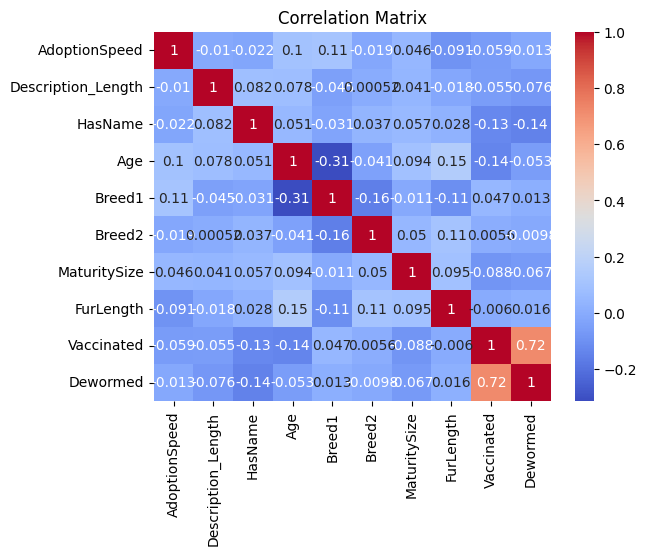

In [269]:
cols = ['AdoptionSpeed','Description_Length','HasName','Age', 'Breed1', 'Breed2', 'MaturitySize', 'FurLength', 'Vaccinated',
       'Dewormed', 'Sterilized', 'Health', 'Quantity', 'Fee', 'State',
       'VideoAmt', 'PhotoAmt', 'Description_Length', 'HasName', 'Type_1',
       'Type_2', 'Gender_1', 'Gender_2', 'Gender_3']
corr_df = train[cols[:10]]
# # Explore correlations
correlation_matrix = corr_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [270]:
# Convert categorical variables to numerical using one-hot encoding
# train = pd.get_dummies(train, columns=['Type', 'Gender', 'Color1', 'Color2', 'Color3'])


In [108]:
train.head()

Type         Name  Age  Breed1  Breed2  Gender  Color1  Color2  Color3  \
0     2       Nibble    3     299       0       1       1       7       0   
1     2  No Name Yet    1     265       0       1       1       2       0   
2     1       Brisco    1     307       0       1       2       7       0   
3     1         Miko    4     307       0       2       1       2       0   
4     1       Hunter    1     307       0       1       1       0       0   

   MaturitySize  FurLength  Vaccinated  Dewormed  Sterilized  Health  \
0             1          1           2         2           2       1   
1             2          2           3         3           3       1   
2             2          2           1         1           2       1   
3             2          1           1         1           2       1   
4             2          1           2         2           2       1   

   Quantity  Fee  State                         RescuerID  VideoAmt  \
0         1  100  41326  8480853f516546f6cf33aa88cd76c379         0   
1         1    0  41401  3082c7125d8fb66f7dd4bff4192c8b14         0   
2         1    0  41326  fa90fa5b1ee11c86938398b60abc32cb         0   
3         1  150  41401  9238e4f44c71a75282e62f7136c6b240         0   
4         1    0  41326  95481e953f8aed9ec3d16fc4509537e8         0   

                                         Description      PetID  PhotoAmt  \
0  Nibble is a 3+ month old ball of cuteness. He ...  86e1089a3       1.0   
1  I just found it alone yesterday near my apartm...  6296e909a       2.0   
2  Their pregnant mother was dumped by her irresp...  3422e4906       7.0   
3  Good guard dog, very alert, active, obedience ...  5842f1ff5       8.0   
4  This handsome yet cute boy is up for adoption....  850a43f90       3.0   

   AdoptionSpeed  Description_Length  HasName  polarity  subjectivity  
0              2                 359        1  0.130357      0.407143  
1              0                 118        1  0.100000      0.400000  
2              3                 393        1  0.261905      0.542857  
3              2                 146        1  0.341146      0.437500  
4              2                 390        1  0.400000      0.743750

In [22]:
np.where(train['Age']>100)

(array([  113,   145,   513,  1057,  1141,  1363,  1703,  1858,  1867,
         2263,  2497,  2767,  2830,  3195,  3684,  3931,  3998,  4071,
         4344,  4456,  4522,  4617,  4796,  5007,  5067,  5160,  5485,
         5535,  5569,  5593,  6264,  6569,  6618,  6666,  6722,  6894,
         6992,  7166,  7250,  7289,  7482,  7512,  7614,  7823,  8058,
         8065,  8304,  8492,  8944,  9267,  9378,  9563,  9970, 10089,
        10128, 10337, 10426, 10501, 10658, 10737, 10917, 11087, 11172,
        11216, 11314, 11523, 11605, 11640, 11968, 12526, 12575, 12621,
        12737, 12855, 12947, 13079, 13398, 13493, 13665, 13744, 14189,
        14303, 14637, 14732], dtype=int64),)

# Features Version 1

In [68]:
# Load data
train = pd.read_csv('input/train/train.csv')
test = pd.read_csv('input/test/test.csv')
breed_labels = pd.read_csv('input/breed_labels.csv')
color_labels = pd.read_csv('input/color_labels.csv')
state_labels = pd.read_csv('input/state_labels.csv')

# Create a new feature based on the length of the description
train['Description_Length'] = train['Description'].apply(lambda x: len(str(x)))
# Create a feature indicating whether a pet has a name or not
train['HasName'] = train['Name'].apply(lambda x: 0 if pd.isnull(x) else 1)




In [54]:
train.shape

(14993, 26)

# Feature Version 2

In [43]:
# Load data
train = pd.read_csv('input/train/train.csv')
test = pd.read_csv('input/test/test.csv')
breed_labels = pd.read_csv('input/breed_labels.csv')
color_labels = pd.read_csv('input/color_labels.csv')
state_labels = pd.read_csv('input/state_labels.csv')

def get_polarity(text):
    return TextBlob(text).sentiment.polarity

def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity


# Create a new feature based on the length of the description
train['Description_Length'] = train['Description'].apply(lambda x: len(str(x)))
# Create a feature indicating whether a pet has a name or not
train['HasName'] = train['Name'].apply(lambda x: 0 if pd.isnull(x) else 1)


train['Polarity'] = train['Description'].astype(str).apply(get_polarity)
train['Subjectivity'] = train['Description'].astype(str).apply(get_subjectivity)




In [46]:
train.shape

(14993, 29)

In [45]:
to_scale = ['AgeScaled']
scale_num = ['Age']
# for column in to_scale:
train[to_scale] = (train[scale_num] - train[scale_num].mean()) / train[scale_num].std()
train.columns

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed',
       'Description_Length', 'HasName', 'Polarity', 'Subjectivity',
       'AgeScaled'],
      dtype='object')

In [42]:
train['Age'][:5],train['AgeScaled'][:5]

(0   -0.410452
 1   -0.520610
 2   -0.520610
 3   -0.355373
 4   -0.520610
 Name: Age, dtype: float64,
 0   -0.410452
 1   -0.520610
 2   -0.520610
 3   -0.355373
 4   -0.520610
 Name: AgeScaled, dtype: float64)

# F V 2.5

In [60]:
# Load data
train = pd.read_csv('input/train/train.csv')
test = pd.read_csv('input/test/test.csv')
breed_labels = pd.read_csv('input/breed_labels.csv')
color_labels = pd.read_csv('input/color_labels.csv')
state_labels = pd.read_csv('input/state_labels.csv')
df_image = pd.read_csv("image_features.csv", header = 0)

def get_polarity(text):
    return TextBlob(text).sentiment.polarity

def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def get_features(train):
    # Create a new feature based on the length of the description
    train['Description_Length'] = train['Description'].apply(lambda x: len(str(x)))
    # Create a feature indicating whether a pet has a name or not
    train['HasName'] = train['Name'].apply(lambda x: 0 if pd.isnull(x) else 1)


#     train['Polarity'] = train['Description'].astype(str).apply(get_polarity)
    train['Subjectivity'] = train['Description'].astype(str).apply(get_subjectivity)

    # Adding features engineering for train dataset
    to_scale = ['AgeScaled']
    scale_num = ['Age']
    train[to_scale] = (train[scale_num] - train[scale_num].mean()) / train[scale_num].std()

    # Concatenating Breed1, Age and Furlength features
    train['Breed1AgeFurLength'] = (train['Breed1'].astype(str) + np.abs(train['AgeScaled']).astype(str) + train['FurLength'].astype(str)).astype(float)
    train['Breed2AgeFurLength'] = (train['Breed2'].astype(str) + np.abs(train['AgeScaled']).astype(str) + train['FurLength'].astype(str)).astype(float)

    # Concatenating binary features such as Vaccinated, Dewormed and Sterilized
    train['VDSCombination'] = (train['Vaccinated'].astype(str) + train['Dewormed'].astype(str) + train['Sterilized'].astype(str)).astype(float)

    # Creating a color count feature without including cases where any color is 0
    train['ColorCount'] = train[['Color1', 'Color2', 'Color3']].apply(lambda row: len([color for color in row if color != 0]), axis=1)

    # Creating a total visual media feature
    train['TotalVisualMedia'] = train['PhotoAmt'] + train['VideoAmt']

    # Creating a description length feature
    train['DescriptionLength'] = train['Description'].apply(lambda x: len(str(x)))

    # Creating a sentiment score feature
    train['SentimentScore'] = train['Description'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    
    #Name_word_len, 'RescuerID_3', 'RescuerID_5', 'Description_len', 'PhotoAmt', 'Name_word_len', 'is_emoji'
    train['Name_word_len'] = train['Name'].fillna('').apply(lambda x : len(x.split(' ')))

#     train['RescuerID_1'] = (train['RescuerID'] == 'fa90fa5b1ee11c86938398b60abc32cb').astype(int)
#     train['RescuerID_2'] = (train['RescuerID'] == 'aa66486163b6cbc25ea62a34b11c9b91').astype(int)
#     train['RescuerID_3'] = (train['RescuerID'] == 'c00756f2bdd8fa88fc9f07a8309f7d5d').astype(int)
#     train['RescuerID_4'] = (train['RescuerID'] == 'b53c34474d9e24574bcec6a3d3306a0d').astype(int)
#     train['RescuerID_5'] = (train['RescuerID'] == 'b770bac0ca797cf1433c48a35d30c4cb').astype(int)

    to_drop = ['AgeScaled']
    train = train.drop(to_drop, axis = 1)
    
    # Adding image features to dataset

    # First finding the position of '-' in PetID
    df_image['pos'] = df_image['PetID'].str.find('-')
    df_image.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

    # Using position to slice PetID using a lambda function
    df_image['PetID'] = df_image.apply(lambda x: x['PetID'][0:x['pos']],axis=1)
#     df_image['PetID'] = df_image['PetID'].apply(lambda x : x.split('-')[0])
    
    df_image.drop(columns=['pos'], axis=1, inplace=True)

    train = pd.merge(train, df_image, how="inner", on=["PetID"], copy=True)

    return train
train = get_features(train)

In [61]:
train.shape

(58311, 42)

In [62]:
train.columns

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed',
       'Description_Length', 'HasName', 'Subjectivity', 'Breed1AgeFurLength',
       'Breed2AgeFurLength', 'VDSCombination', 'ColorCount',
       'TotalVisualMedia', 'DescriptionLength', 'SentimentScore',
       'Name_word_len', 'Energy', 'Contrast', 'Correlation', 'Entropy', 'Mean',
       'Std_Dev', 'num_checkpoints'],
      dtype='object')

In [112]:
train['Breed1AgeFurLength'], train['Breed1']

(0        2990.410452
 1        2650.520610
 2        2650.520610
 3        3070.520610
 4        3070.520610
             ...     
 58306    2650.465531
 58307    2660.079979
 58308    2660.079979
 58309    2660.079979
 58310    3070.520610
 Name: Breed1AgeFurLength, Length: 58311, dtype: float64,
 0        299
 1        265
 2        265
 3        307
 4        307
         ... 
 58306    265
 58307    266
 58308    266
 58309    266
 58310    307
 Name: Breed1, Length: 58311, dtype: int64,
 0        299
 1        265
 2        265
 3        307
 4        307
         ... 
 58306    265
 58307    266
 58308    266
 58309    266
 58310    307
 Name: Breed1, Length: 58311, dtype: object)

In [58]:
# Load data
train = pd.read_csv('input/train/train.csv')
test = pd.read_csv('input/test/test.csv')
breed_labels = pd.read_csv('input/breed_labels.csv')
color_labels = pd.read_csv('input/color_labels.csv')
state_labels = pd.read_csv('input/state_labels.csv')
df_image = pd.read_csv("image_features.csv", header = 0)

def get_features(train):

    
    # Adding image features to dataset

    # First finding the position of '-' in PetID
    df_image['pos'] = df_image['PetID'].str.find('-')
    df_image.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

    # Using position to slice PetID using a lambda function
#     df_image['PetID'] = df_image.apply(lambda x: x['PetID'][0:x['pos']],axis=1)
    df_image['PetID'] = df_image['PetID'].apply(lambda x : x.split('-')[0])

    df_image.drop(columns=['pos'], axis=1, inplace=True)

    train = pd.merge(train, df_image, how="inner", on=["PetID"], copy=True)

    return train


In [55]:
train = get_features(train)
train.head()

Type         Name  Age  Breed1  Breed2  Gender  Color1  Color2  Color3  \
0     2       Nibble    3     299       0       1       1       7       0   
1     2  No Name Yet    1     265       0       1       1       2       0   
2     1       Brisco    1     307       0       1       2       7       0   
3     1         Miko    4     307       0       2       1       2       0   
4     1       Hunter    1     307       0       1       1       0       0   

   MaturitySize  ...  Health  Quantity  Fee  State  \
0             1  ...       1         1  100  41326   
1             2  ...       1         1    0  41401   
2             2  ...       1         1    0  41326   
3             2  ...       1         1  150  41401   
4             2  ...       1         1    0  41326   

                          RescuerID  VideoAmt  \
0  8480853f516546f6cf33aa88cd76c379         0   
1  3082c7125d8fb66f7dd4bff4192c8b14         0   
2  fa90fa5b1ee11c86938398b60abc32cb         0   
3  9238e4f44c71a75282e62f7136c6b240         0   
4  95481e953f8aed9ec3d16fc4509537e8         0   

                                         Description      PetID PhotoAmt  \
0  Nibble is a 3+ month old ball of cuteness. He ...  86e1089a3      1.0   
1  I just found it alone yesterday near my apartm...  6296e909a      2.0   
2  Their pregnant mother was dumped by her irresp...  3422e4906      7.0   
3  Good guard dog, very alert, active, obedience ...  5842f1ff5      8.0   
4  This handsome yet cute boy is up for adoption....  850a43f90      3.0   

   AdoptionSpeed  
0              2  
1              0  
2              3  
3              2  
4              2  

[5 rows x 24 columns]

In [59]:
train = get_features(train)
train.head()

Type         Name  Age  Breed1  Breed2  Gender  Color1  Color2  Color3  \
0     2       Nibble    3     299       0       1       1       7       0   
1     2  No Name Yet    1     265       0       1       1       2       0   
2     2  No Name Yet    1     265       0       1       1       2       0   
3     1       Brisco    1     307       0       1       2       7       0   
4     1       Brisco    1     307       0       1       2       7       0   

   MaturitySize  ...      PetID  PhotoAmt  AdoptionSpeed    Energy  \
0             1  ...  86e1089a3       1.0              2  0.035852   
1             2  ...  6296e909a       2.0              0  0.024294   
2             2  ...  6296e909a       2.0              0  0.020795   
3             2  ...  3422e4906       7.0              3  0.031033   
4             2  ...  3422e4906       7.0              3  0.033033   

     Contrast  Correlation   Entropy        Mean    Std_Dev  num_checkpoints  
0  157.460689     0.986806  7.433718   95.712315  77.438182              482  
1   67.326433     0.993081  7.606400   80.975930  70.301201              242  
2   59.355293     0.993102  7.821693  124.377094  66.107520              133  
3   46.870192     0.986000  7.201306  125.111786  50.108971              221  
4   36.242573     0.994397  7.279035  164.539797  57.642161              198  

[5 rows x 31 columns]

In [45]:
train.columns

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed',
       'Description_Length', 'HasName', 'Subjectivity', 'Breed1AgeFurLength',
       'Breed2AgeFurLength', 'VDSCombination', 'ColorCount',
       'TotalVisualMedia', 'DescriptionLength', 'SentimentScore',
       'Name_word_len', 'Energy', 'Contrast', 'Correlation', 'Entropy', 'Mean',
       'Std_Dev', 'num_checkpoints'],
      dtype='object')

In [55]:
train = get_features(train)

In [63]:
train.shape

(58311, 42)

In [64]:
train.columns

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed',
       'Description_Length', 'HasName', 'Subjectivity', 'Breed1AgeFurLength',
       'Breed2AgeFurLength', 'VDSCombination', 'ColorCount',
       'TotalVisualMedia', 'DescriptionLength', 'SentimentScore',
       'Name_word_len', 'Energy', 'Contrast', 'Correlation', 'Entropy', 'Mean',
       'Std_Dev', 'num_checkpoints'],
      dtype='object')

# Feature V3

In [30]:
# Load data
from sklearn.decomposition import TruncatedSVD
import cv2
from keras.applications.densenet import preprocess_input, DenseNet121

train = pd.read_csv('input/train/train.csv')
test = pd.read_csv('input/test/test.csv')
breed_labels = pd.read_csv('input/breed_labels.csv')
color_labels = pd.read_csv('input/color_labels.csv')
state_labels = pd.read_csv('input/state_labels.csv')



train = get_features(train)




print('Completed getting tabular features')


from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Input, Lambda, AveragePooling1D
import keras.backend as K

img_size = 256
batch_size = 256

def resize_to_square(im):
    old_size = im.shape[:2]
    ratio = float(img_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    im = cv2.resize(im, (new_size[1], new_size[0]))
    delta_w = img_size - new_size[1]
    delta_h = img_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,value=color)
    return new_im

def load_image(path, pet_id):
    image = cv2.imread(f'{path}{pet_id}-1.jpg')
    new_image = resize_to_square(image)
    new_image = preprocess_input(new_image)
    return new_image

inp = Input((256,256,3))
backbone = DenseNet121(input_tensor = inp, 
                       weights="input/densenet-keras/DenseNet-BC-121-32-no-top.h5",
                       include_top = False)
x = backbone.output
x = GlobalAveragePooling2D()(x)
x = Lambda(lambda x: K.expand_dims(x,axis = -1))(x)
x = AveragePooling1D(4)(x)
out = Lambda(lambda x: x[:,:,0])(x)

m = Model(inp,out)

pet_ids = train['PetID'].values
n_batches = len(pet_ids) // batch_size + 1

features = {}
for b in tqdm(range(n_batches)):
    start = b*batch_size
    end = (b+1)*batch_size
    batch_pets = pet_ids[start:end]
    batch_images = np.zeros((len(batch_pets),img_size,img_size,3))
    for i,pet_id in enumerate(batch_pets):
        try:
            batch_images[i] = load_image("input/train_images/", pet_id)
        except:
            pass
    batch_preds = m.predict(batch_images)
    for i,pet_id in enumerate(batch_pets):
        features[pet_id] = batch_preds[i]
        
train_feats = pd.DataFrame.from_dict(features, orient='index')
train_feats.columns = [f'pic_{i}' for i in range(train_feats.shape[1])]
train_feats = train_feats.reset_index()
train_feats.rename({'index': 'PetID'}, axis='columns', inplace=True)

n_components = 32
svd_ = TruncatedSVD(n_components=n_components, random_state=1337)

# features_df = pd.concat([train_feats, test_feats], axis=0)
features = train_feats[[f'pic_{i}' for i in range(256)]].values

svd_col = svd_.fit_transform(features)
svd_col = pd.DataFrame(svd_col)
svd_col = svd_col.add_prefix('IMG_SVD_')

all_ids = train['PetID']#pd.concat([train, test], axis=0, ignore_index=True, sort=False)[['PetID']]
img_features = pd.concat([all_ids, svd_col], axis=1)
# img_features.to_csv('img_features_densenet121.csv')
train = train.merge(img_features, how='left', on='PetID')

Completed getting tabular features


  0%|                                                                                           | 0/59 [00:00<?, ?it/s]

8/8 [==============================] - 15s 2s/step


  2%|█▍                                                                                 | 1/59 [00:17<17:18, 17.90s/it]

8/8 [==============================] - 14s 2s/step


  3%|██▊                                                                                | 2/59 [00:34<16:21, 17.22s/it]

8/8 [==============================] - 15s 2s/step


  5%|████▏                                                                              | 3/59 [00:51<15:58, 17.11s/it]

8/8 [==============================] - 14s 2s/step


  7%|█████▋                                                                             | 4/59 [01:07<15:19, 16.72s/it]

8/8 [==============================] - 14s 2s/step


  8%|███████                                                                            | 5/59 [01:24<15:01, 16.69s/it]

8/8 [==============================] - 14s 2s/step


 10%|████████▍                                                                          | 6/59 [01:40<14:42, 16.64s/it]

8/8 [==============================] - 14s 2s/step


 12%|█████████▊                                                                         | 7/59 [01:57<14:23, 16.61s/it]

8/8 [==============================] - 14s 2s/step


 14%|███████████▎                                                                       | 8/59 [02:13<14:01, 16.50s/it]

8/8 [==============================] - 15s 2s/step


 15%|████████████▋                                                                      | 9/59 [02:30<13:48, 16.58s/it]

8/8 [==============================] - 14s 2s/step


 17%|█████████████▉                                                                    | 10/59 [02:47<13:31, 16.57s/it]

8/8 [==============================] - 15s 2s/step


 19%|███████████████▎                                                                  | 11/59 [03:03<13:20, 16.67s/it]

8/8 [==============================] - 15s 2s/step


 20%|████████████████▋                                                                 | 12/59 [03:20<13:08, 16.78s/it]

8/8 [==============================] - 14s 2s/step


 22%|██████████████████                                                                | 13/59 [03:37<12:44, 16.62s/it]

8/8 [==============================] - 15s 2s/step


 24%|███████████████████▍                                                              | 14/59 [03:55<12:45, 17.02s/it]

8/8 [==============================] - 16s 2s/step


 25%|████████████████████▊                                                             | 15/59 [04:14<12:55, 17.62s/it]

8/8 [==============================] - 15s 2s/step


 27%|██████████████████████▏                                                           | 16/59 [04:31<12:34, 17.54s/it]

8/8 [==============================] - 15s 2s/step


 29%|███████████████████████▋                                                          | 17/59 [04:48<12:07, 17.33s/it]

8/8 [==============================] - 14s 2s/step


 31%|█████████████████████████                                                         | 18/59 [05:04<11:39, 17.07s/it]

8/8 [==============================] - 15s 2s/step


 32%|██████████████████████████▍                                                       | 19/59 [05:22<11:26, 17.16s/it]

8/8 [==============================] - 14s 2s/step


 34%|███████████████████████████▊                                                      | 20/59 [05:38<11:02, 17.00s/it]

8/8 [==============================] - 15s 2s/step


 36%|█████████████████████████████▏                                                    | 21/59 [05:56<10:53, 17.20s/it]

8/8 [==============================] - 15s 2s/step


 37%|██████████████████████████████▌                                                   | 22/59 [06:13<10:36, 17.19s/it]

8/8 [==============================] - 15s 2s/step


 39%|███████████████████████████████▉                                                  | 23/59 [06:30<10:16, 17.13s/it]

8/8 [==============================] - 14s 2s/step


 41%|█████████████████████████████████▎                                                | 24/59 [06:47<09:53, 16.96s/it]

8/8 [==============================] - 14s 2s/step


 42%|██████████████████████████████████▋                                               | 25/59 [07:03<09:27, 16.71s/it]

8/8 [==============================] - 14s 2s/step


 44%|████████████████████████████████████▏                                             | 26/59 [07:19<09:06, 16.55s/it]

8/8 [==============================] - 14s 2s/step


 46%|█████████████████████████████████████▌                                            | 27/59 [07:35<08:47, 16.48s/it]

8/8 [==============================] - 14s 2s/step


 47%|██████████████████████████████████████▉                                           | 28/59 [07:52<08:30, 16.46s/it]

8/8 [==============================] - 14s 2s/step


 49%|████████████████████████████████████████▎                                         | 29/59 [08:08<08:14, 16.47s/it]

8/8 [==============================] - 15s 2s/step


 51%|█████████████████████████████████████████▋                                        | 30/59 [08:26<08:08, 16.84s/it]

8/8 [==============================] - 14s 2s/step


 53%|███████████████████████████████████████████                                       | 31/59 [08:43<07:54, 16.94s/it]

8/8 [==============================] - 14s 2s/step


 54%|████████████████████████████████████████████▍                                     | 32/59 [08:59<07:29, 16.64s/it]

8/8 [==============================] - 15s 2s/step


 56%|█████████████████████████████████████████████▊                                    | 33/59 [09:16<07:13, 16.68s/it]

8/8 [==============================] - 14s 2s/step


 58%|███████████████████████████████████████████████▎                                  | 34/59 [09:32<06:52, 16.50s/it]

8/8 [==============================] - 14s 2s/step


 59%|████████████████████████████████████████████████▋                                 | 35/59 [09:48<06:32, 16.36s/it]

8/8 [==============================] - 14s 2s/step


 61%|██████████████████████████████████████████████████                                | 36/59 [10:05<06:18, 16.44s/it]

8/8 [==============================] - 16s 2s/step


 63%|███████████████████████████████████████████████████▍                              | 37/59 [10:23<06:12, 16.92s/it]

8/8 [==============================] - 17s 2s/step


 64%|████████████████████████████████████████████████████▊                             | 38/59 [10:42<06:10, 17.66s/it]

8/8 [==============================] - 15s 2s/step


 66%|██████████████████████████████████████████████████████▏                           | 39/59 [11:00<05:55, 17.76s/it]

8/8 [==============================] - 15s 2s/step


 68%|███████████████████████████████████████████████████████▌                          | 40/59 [11:17<05:34, 17.58s/it]

8/8 [==============================] - 15s 2s/step


 69%|████████████████████████████████████████████████████████▉                         | 41/59 [11:35<05:16, 17.60s/it]

8/8 [==============================] - 14s 2s/step


 71%|██████████████████████████████████████████████████████████▎                       | 42/59 [11:51<04:52, 17.19s/it]

8/8 [==============================] - 14s 2s/step


 73%|███████████████████████████████████████████████████████████▊                      | 43/59 [12:07<04:31, 16.96s/it]

8/8 [==============================] - 14s 2s/step


 75%|█████████████████████████████████████████████████████████████▏                    | 44/59 [12:24<04:10, 16.69s/it]

8/8 [==============================] - 14s 2s/step


 76%|██████████████████████████████████████████████████████████████▌                   | 45/59 [12:40<03:52, 16.59s/it]

8/8 [==============================] - 14s 2s/step


 78%|███████████████████████████████████████████████████████████████▉                  | 46/59 [12:56<03:35, 16.59s/it]

8/8 [==============================] - 14s 2s/step


 80%|█████████████████████████████████████████████████████████████████▎                | 47/59 [13:13<03:19, 16.59s/it]

8/8 [==============================] - 15s 2s/step


 81%|██████████████████████████████████████████████████████████████████▋               | 48/59 [13:30<03:03, 16.67s/it]

8/8 [==============================] - 15s 2s/step


 83%|████████████████████████████████████████████████████████████████████              | 49/59 [13:47<02:48, 16.89s/it]

8/8 [==============================] - 15s 2s/step


 85%|█████████████████████████████████████████████████████████████████████▍            | 50/59 [14:04<02:31, 16.85s/it]

8/8 [==============================] - 14s 2s/step


 86%|██████████████████████████████████████████████████████████████████████▉           | 51/59 [14:20<02:13, 16.69s/it]

8/8 [==============================] - 14s 2s/step


 88%|████████████████████████████████████████████████████████████████████████▎         | 52/59 [14:37<01:56, 16.58s/it]

8/8 [==============================] - 14s 2s/step


 90%|█████████████████████████████████████████████████████████████████████████▋        | 53/59 [14:53<01:38, 16.44s/it]

8/8 [==============================] - 14s 2s/step


 92%|███████████████████████████████████████████████████████████████████████████       | 54/59 [15:09<01:22, 16.40s/it]

8/8 [==============================] - 15s 2s/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 55/59 [15:26<01:06, 16.61s/it]

8/8 [==============================] - 15s 2s/step


 95%|█████████████████████████████████████████████████████████████████████████████▊    | 56/59 [15:44<00:50, 16.86s/it]

8/8 [==============================] - 14s 2s/step


 97%|███████████████████████████████████████████████████████████████████████████████▏  | 57/59 [16:00<00:33, 16.71s/it]

8/8 [==============================] - 14s 2s/step


 98%|████████████████████████████████████████████████████████████████████████████████▌ | 58/59 [16:16<00:16, 16.59s/it]

5/5 [==============================] - 9s 2s/step


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [16:27<00:00, 16.74s/it]


AttributeError: module 'pandas' has no attribute 'to_csv'

In [31]:
img_features.to_csv('img_features_densenet121.csv')
train = train.merge(img_features, how='left', on='PetID')
# train.to_csv('total_features.csv')


In [76]:
train_feats.head()

PetID     pic_0     pic_1     pic_2     pic_3     pic_4     pic_5  \
0  86e1089a3  0.002188  0.159618  0.038098  0.016042  0.057492  0.002475   
1  6296e909a  0.003436  0.070380  0.027160  0.024571  0.183980  0.002533   
2  3422e4906  0.003049  0.059617  0.020863  0.017770  0.123510  0.002557   
3  5842f1ff5  0.002585  0.198944  0.102544  0.015014  0.087345  0.001525   
4  850a43f90  0.002521  0.126629  0.092010  0.021418  0.256435  0.002221   

      pic_6     pic_7     pic_8  ...   pic_246   pic_247   pic_248   pic_249  \
0  0.006010  0.005836  0.056111  ...  0.637377  0.471051  0.492751  0.905257   
1  0.006410  0.007834  0.116600  ...  0.578995  0.659671  0.482345  0.939887   
2  0.004631  0.003186  0.086524  ...  0.724009  0.800381  1.051816  1.060419   
3  0.006306  0.004840  0.073845  ...  1.519123  0.643889  0.108681  1.435288   
4  0.005213  0.004104  0.073800  ...  0.731181  0.619793  0.372244  0.786537   

    pic_250   pic_251   pic_252   pic_253   pic_254   pic_255  
0  0.370729  0.757239  1.674540  0.933842  0.472826  0.987627  
1  1.020734  1.522014  0.847937  0.557507  0.494313  1.127991  
2  1.732831  1.734095  1.158142  1.387126  0.476071  0.904636  
3  1.584310  1.576919  0.465382  1.140381  0.785168  1.270468  
4  0.523966  0.772164  1.185914  0.440742  0.301059  0.470078  

[5 rows x 257 columns]

In [34]:
img_features.head()

PetID  IMG_SVD_0  IMG_SVD_1  IMG_SVD_2  IMG_SVD_3  IMG_SVD_4  \
0  86e1089a3   8.511766   1.444202   0.675308   1.755868   0.865962   
1  6296e909a   9.032441   0.003591   1.891665  -0.183987   0.117828   
2  3422e4906   8.481477  -1.691183  -0.233407   0.132987  -1.152724   
3  5842f1ff5   9.445466  -1.354451   1.406327   1.156624   1.008837   
4  850a43f90   7.458097  -0.889599   0.312963   1.948659  -1.122301   

   IMG_SVD_5  IMG_SVD_6  IMG_SVD_7  IMG_SVD_8  ...  IMG_SVD_22  IMG_SVD_23  \
0  -0.220783  -0.824086   0.874020  -0.166271  ...    0.044977    0.036408   
1   0.032837  -1.263023   0.123951  -0.386072  ...   -0.109792    0.280217   
2  -0.360525  -0.244551  -0.262426   0.598962  ...    0.174609   -0.480327   
3  -0.957348  -1.280471  -0.548080   0.055572  ...   -0.534671   -0.082518   
4  -0.157807  -1.160421   0.426153  -0.020158  ...    0.370174   -0.105792   

   IMG_SVD_24  IMG_SVD_25  IMG_SVD_26  IMG_SVD_27  IMG_SVD_28  IMG_SVD_29  \
0    0.078817   -0.030512    0.056530    0.289120    0.069832    0.201541   
1   -0.772585    0.373988    0.554430   -0.094436    0.629933   -0.261518   
2   -0.383762   -0.330501   -0.309375    0.306382   -0.220225    0.555229   
3    0.292845   -0.241975    0.072914   -0.367009   -0.019004    0.111996   
4    0.466829   -0.052422    0.028332    0.046723   -0.469268    0.293980   

   IMG_SVD_30  IMG_SVD_31  
0    0.395681    0.235336  
1    0.127906    0.092801  
2   -0.077617    0.218833  
3   -0.286972   -0.194758  
4    0.289349   -0.252691  

[5 rows x 33 columns]

In [35]:
train.head()

Type         Name  Age  Breed1  Breed2  Gender  Color1  Color2  Color3  \
0     2       Nibble    3     299       0       1       1       7       0   
1     2  No Name Yet    1     265       0       1       1       2       0   
2     1       Brisco    1     307       0       1       2       7       0   
3     1         Miko    4     307       0       2       1       2       0   
4     1       Hunter    1     307       0       1       1       0       0   

   MaturitySize  ...  IMG_SVD_22  IMG_SVD_23  IMG_SVD_24  IMG_SVD_25  \
0             1  ...    0.044977    0.036408    0.078817   -0.030512   
1             2  ...   -0.109792    0.280217   -0.772585    0.373988   
2             2  ...    0.174609   -0.480327   -0.383762   -0.330501   
3             2  ...   -0.534671   -0.082518    0.292845   -0.241975   
4             2  ...    0.370174   -0.105792    0.466829   -0.052422   

   IMG_SVD_26  IMG_SVD_27  IMG_SVD_28  IMG_SVD_29 IMG_SVD_30  IMG_SVD_31  
0    0.056530    0.289120    0.069832    0.201541   0.395681    0.235336  
1    0.554430   -0.094436    0.629933   -0.261518   0.127906    0.092801  
2   -0.309375    0.306382   -0.220225    0.555229  -0.077617    0.218833  
3    0.072914   -0.367009   -0.019004    0.111996  -0.286972   -0.194758  
4    0.028332    0.046723   -0.469268    0.293980   0.289349   -0.252691  

[5 rows x 67 columns]

# F V4

In [81]:
train.shape

(14993, 60)

# Models

## Without encodings

In [50]:
def rf_woe(train):
    cols_to_drop = ['PetID', 'AdoptionSpeed','Description','Name','RescuerID']
    X = train.drop(cols_to_drop, axis=1)
    y = train['AdoptionSpeed']
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


    # Using RandomForestClassifier as an example
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Predictions on the validation set
    y_pred = model.predict(X_valid)
    x_pred = model.predict(X_train)

    # Evaluate the model
    test_accuracy = accuracy_score(y_valid, y_pred)
    train_accuracy = accuracy_score(y_train, x_pred)
    print("Random Forest train accuracy: {:.2f}%".format(train_accuracy * 100))
    print("Random Forest test accuracy: {:.2f}%".format(test_accuracy * 100))

    # Classification report and confusion matrix
    print(classification_report(y_valid, y_pred))
    conf_matrix = confusion_matrix(y_valid, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

Random Forest train accuracy: 99.80%
Random Forest test accuracy: 42.78%
              precision    recall  f1-score   support

           0       0.78      0.08      0.14        92
           1       0.36      0.33      0.35       627
           2       0.37      0.39      0.38       806
           3       0.39      0.29      0.33       641
           4       0.52      0.68      0.59       833

    accuracy                           0.43      2999
   macro avg       0.48      0.35      0.36      2999
weighted avg       0.43      0.43      0.41      2999



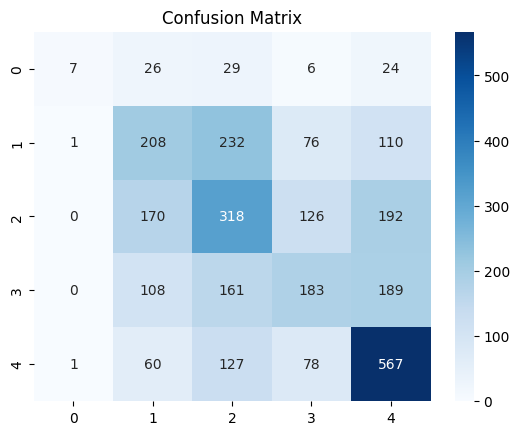

In [14]:



rf_woe(train)

Random Forest train accuracy: 99.83%
Random Forest test accuracy: 43.11%
              precision    recall  f1-score   support

           0       0.67      0.07      0.12        92
           1       0.39      0.37      0.38       627
           2       0.38      0.40      0.39       806
           3       0.40      0.25      0.31       641
           4       0.51      0.68      0.58       833

    accuracy                           0.43      2999
   macro avg       0.47      0.35      0.36      2999
weighted avg       0.43      0.43      0.42      2999



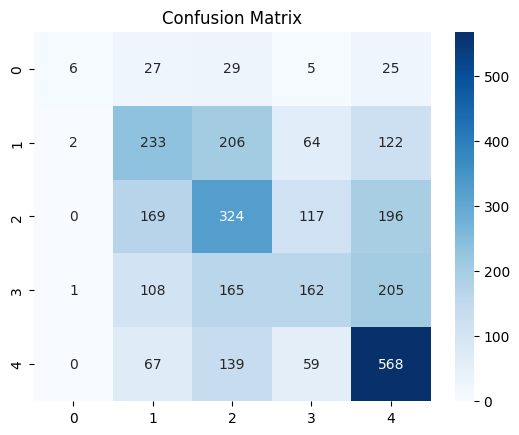

In [60]:
rf_woe(train)#fv2

Random Forest train accuracy: 100.00%
Random Forest test accuracy: 84.40%
              precision    recall  f1-score   support

           0       0.98      0.60      0.74       253
           1       0.82      0.82      0.82      2280
           2       0.83      0.86      0.85      3333
           3       0.92      0.83      0.87      3033
           4       0.80      0.88      0.84      2764

    accuracy                           0.84     11663
   macro avg       0.87      0.80      0.82     11663
weighted avg       0.85      0.84      0.84     11663



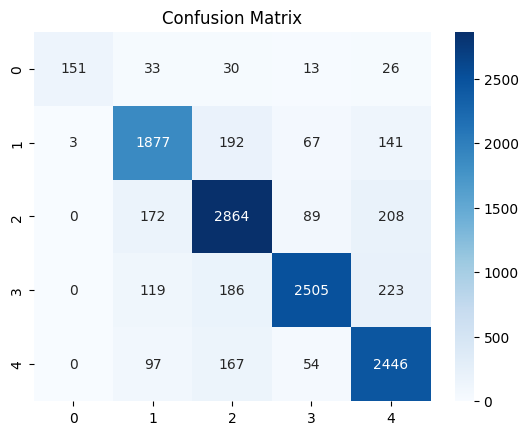

In [51]:
rf_woe(train) #fv2.5 no other feat transformations

Random Forest train accuracy: 100.00%
Random Forest test accuracy: 92.79%
              precision    recall  f1-score   support

           0       1.00      0.84      0.91       253
           1       0.91      0.92      0.91      2280
           2       0.92      0.94      0.93      3333
           3       0.98      0.92      0.95      3033
           4       0.90      0.94      0.92      2764

    accuracy                           0.93     11663
   macro avg       0.94      0.91      0.92     11663
weighted avg       0.93      0.93      0.93     11663



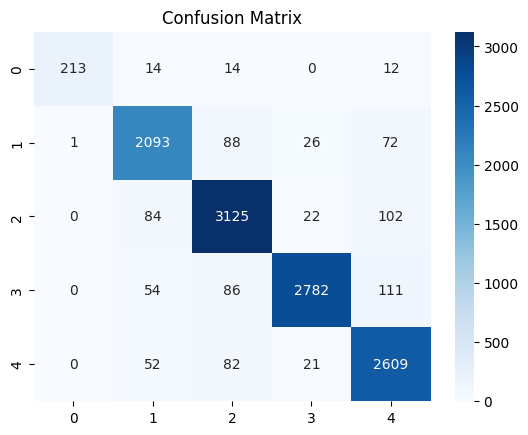

In [25]:
rf_woe(train) #fv2.5

Random Forest train accuracy: 100.00%
Random Forest test accuracy: 40.48%
              precision    recall  f1-score   support

           0       1.00      0.03      0.06        92
           1       0.37      0.25      0.30       627
           2       0.34      0.47      0.39       806
           3       0.37      0.19      0.25       641
           4       0.49      0.66      0.57       833

    accuracy                           0.40      2999
   macro avg       0.51      0.32      0.32      2999
weighted avg       0.42      0.40      0.38      2999



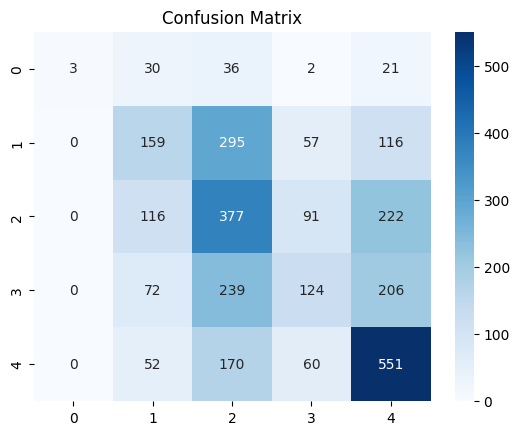

In [80]:
rf_woe(train) #fv3

Random Forest train accuracy: 100.00%
Random Forest test accuracy: 41.18%
              precision    recall  f1-score   support

           0       0.75      0.03      0.06        92
           1       0.36      0.29      0.32       627
           2       0.35      0.47      0.40       806
           3       0.37      0.17      0.24       641
           4       0.51      0.67      0.58       833

    accuracy                           0.41      2999
   macro avg       0.47      0.33      0.32      2999
weighted avg       0.41      0.41      0.39      2999



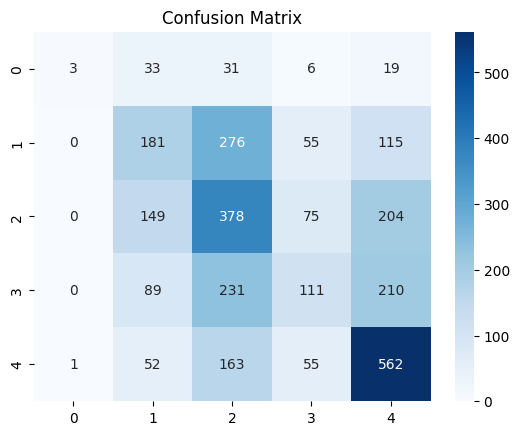

In [15]:
rf_woe(train) #fv4


## With Encoding

In [66]:
def rf_we(train):
    numeric_features = ['Age','Fee','VideoAmt','PhotoAmt','Quantity']

    categorical_features = ['Type', 'Color1', 'Color2', 'Gender', 'MaturitySize', 
                        'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Breed1','Gender']

    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])


    categorical_transformer = Pipeline(steps=[

        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])


    cols_to_drop = ['PetID', 'AdoptionSpeed','Description','Name','RescuerID']
    X = train.drop(cols_to_drop, axis=1)
    y = train['AdoptionSpeed']
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


    model_1 = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', 
                       RandomForestClassifier(n_jobs=-1, n_estimators=200)
                         )])  
    model_1.fit(X_train,y_train)

    # make predictions on test data
    y_model_randomforest = model_1.predict(X_valid)

    # accuracy score
    train_accuracy_rf = model_1.score(X_train, y_train)
    test_accuracy_rf = model_1.score(X_valid, y_valid)
    print("Random Forest train accuracy: {:.2f}%".format(train_accuracy_rf * 100))
    print("Random Forest test accuracy: {:.2f}%".format(test_accuracy_rf * 100))
    return model_1

In [17]:

rf_we(train)

Random Forest train accuracy: 95.21%
Random Forest test accuracy: 37.25%


In [62]:
rf_we(train) #v2

Random Forest train accuracy: 99.63%
Random Forest test accuracy: 39.65%


In [68]:
model_test = rf_we(train) #v2.5

Random Forest train accuracy: 96.60%
Random Forest test accuracy: 90.71%


In [99]:
test_d = train.iloc[[0]]
test_d.iloc[0] = 0
test_d
# test_d['Name_word_len'] = 1

Type Name  Age  Breed1  Breed2  Gender  Color1  Color2  Color3  \
0     0    0    0       0       0       0       0       0       0   

   MaturitySize  ...  DescriptionLength  SentimentScore  Name_word_len  \
0             0  ...                  0             0.0              0   

   Energy  Contrast  Correlation  Entropy  Mean Std_Dev  num_checkpoints  
0     0.0       0.0          0.0      0.0   0.0     0.0                0  

[1 rows x 42 columns]

In [115]:
train['Breed1AgeFurLength'].value_counts()

Breed1AgeFurLength
3070.465531    6674
3070.520610    5113
2660.465531    4009
3070.410452    3099
2660.410452    2653
               ... 
2950.079979       1
2170.085258       1
2500.746204       1
611.407150        1
1850.085258       1
Name: count, Length: 1463, dtype: int64

In [125]:
train.iloc[[0]].dtypes

Type                    int64
Name                   object
Age                     int64
Breed1                  int64
Breed2                  int64
Gender                  int64
Color1                  int64
Color2                  int64
Color3                  int64
MaturitySize            int64
FurLength               int64
Vaccinated              int64
Dewormed                int64
Sterilized              int64
Health                  int64
Quantity                int64
Fee                     int64
State                   int64
RescuerID              object
VideoAmt                int64
Description            object
PetID                  object
PhotoAmt              float64
AdoptionSpeed           int64
Description_Length      int64
HasName                 int64
Subjectivity          float64
Breed1AgeFurLength    float64
Breed2AgeFurLength    float64
VDSCombination        float64
ColorCount              int64
TotalVisualMedia      float64
DescriptionLength       int64
SentimentS

In [26]:
import pandas as pd
import requests


# Select the first row of the DataFrame
data_to_send = test.iloc[[8]].to_dict(orient='records')[0]
print(data_to_send)
# URL of your Flask API endpoint
api_url = "http://localhost:5000/predict"

# Make a POST request to the API endpoint with the data
response = requests.post(api_url,files = None, data=data_to_send)

# Check the response from the API
print(response.text)


{'Type': 2, 'Name': 'Timmy And Boboy', 'Age': 7, 'Breed1': 247, 'Breed2': 266, 'Gender': 3, 'Color1': 2, 'Color2': 4, 'Color3': 5, 'MaturitySize': 2, 'FurLength': 2, 'Vaccinated': 1, 'Dewormed': 1, 'Sterilized': 1, 'Health': 1, 'Quantity': 2, 'Fee': 0, 'State': 41326, 'RescuerID': 'df3f86a2d783512e0d863a47c55a86b7', 'VideoAmt': 0, 'Description': 'Saya ada 2 ekor kitten untuk diberi secara PERCUMA. Semua kitten dah vaksin & deworm. Umur = 7 Bulan Jantan = 2 Ekor (Dah dimandulkan) Lokasi = Puchong Perdana Prefer untuk let go kedua2 sekali coz kitten2 nie tak pernah berpisah. Sesiapa yang berminat, boleh hubungi saya di talian 3 .', 'PetID': '0f82cea1e', 'PhotoAmt': 2.0}
{
  "predictions": "4"
}



In [5]:
# model_test.predict(train.iloc[[5]])
model_test.predict(train.iloc[[1]])

NameError: name 'model_test' is not defined

In [38]:
rf_we(train) #v2.5

Random Forest train accuracy: 96.60%
Random Forest test accuracy: 90.65%


In [42]:
rf_we(train) #v2.5

Random Forest train accuracy: 96.60%
Random Forest test accuracy: 90.60%


In [46]:
rf_we(train) #v2.5 with subjectivity

Random Forest train accuracy: 96.60%
Random Forest test accuracy: 90.77%


In [49]:
rf_we(train) #v2.5 with polarity 

Random Forest train accuracy: 96.60%
Random Forest test accuracy: 90.56%


In [53]:
rf_we(train) #v2.5 with dscriptio_len and hasname

Random Forest train accuracy: 96.60%
Random Forest test accuracy: 90.61%


In [56]:
rf_we(train) #v2.5 with hasname

Random Forest train accuracy: 96.60%
Random Forest test accuracy: 90.62%


In [24]:
rf_we(train) #v2.5 

Random Forest train accuracy: 96.60%
Random Forest test accuracy: 90.65%


In [48]:
rf_we(train) #v2.5 with img feat and no other transformations

Random Forest train accuracy: 96.60%
Random Forest test accuracy: 90.58%


In [27]:
rf_we(train) #v2.5 with out image feat

Random Forest train accuracy: 95.21%
Random Forest test accuracy: 36.88%


In [36]:
rf_we(train) #v2.5 with  image feat densenet121

Random Forest train accuracy: 95.21%
Random Forest test accuracy: 37.65%


In [17]:
rf_we(train) #v4

Random Forest train accuracy: 95.21%
Random Forest test accuracy: 37.18%


In [61]:
rf_we(train) #v4

Random Forest train accuracy: 98.01%
Random Forest test accuracy: 97.18%


In [93]:

# numeric_features = ['Age','Fee','VideoAmt','PhotoAmt','Quantity','Subjectivity','Polarity']
numerical_columns = train.select_dtypes(include=['number']).drop(['AdoptionSpeed'],axis = 1)
numeric_features = list(numerical_columns.columns)

categorical_features = ['Type', 'Color1', 'Color2', 'Gender', 'MaturitySize', 
                    'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Breed1','Gender']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])


categorical_transformer = Pipeline(steps=[

    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

cols_to_drop = ['PetID', 'AdoptionSpeed','Description','Name','RescuerID']
X = train.drop(cols_to_drop, axis=1)
y = train['AdoptionSpeed']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


model_1 = Pipeline(steps=[('preprocessor', preprocessor),
                  ('classifier', 
                   RandomForestClassifier(n_jobs=-1, n_estimators=200)
                     )])  
model_1.fit(X_train,y_train)

# make predictions on test data
y_model_randomforest = model_1.predict(X_valid)

# accuracy score
train_accuracy_rf = model_1.score(X_train, y_train)
test_accuracy_rf = model_1.score(X_valid, y_valid)
print("Random Forest train accuracy: {:.2f}%".format(train_accuracy_rf * 100))
print("Random Forest test accuracy: {:.2f}%".format(test_accuracy_rf * 100))


Random Forest train accuracy: 100.00%
Random Forest test accuracy: 41.95%


## With only numerical encoding

In [20]:
numeric_features = ['Age','Fee','VideoAmt','PhotoAmt','Quantity']
    

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
        ])


cols_to_drop = ['PetID', 'AdoptionSpeed','Description','Name','RescuerID']
X = train.drop(cols_to_drop, axis=1)
y = train['AdoptionSpeed']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


model_1 = Pipeline(steps=[('preprocessor', preprocessor),
                  ('classifier', 
                   RandomForestClassifier(n_jobs=-1, n_estimators=200)
                     )])  
model_1.fit(X_train,y_train)

# make predictions on test data
y_model_randomforest = model_1.predict(X_valid)

# accuracy score
train_accuracy_rf = model_1.score(X_train, y_train)
test_accuracy_rf = model_1.score(X_valid, y_valid)
print("Random Forest train accuracy: {:.2f}%".format(train_accuracy_rf * 100))
print("Random Forest test accuracy: {:.2f}%".format(test_accuracy_rf * 100))



Random Forest train accuracy: 51.33%
Random Forest test accuracy: 32.58%


# With Only Categorical Encoding

In [23]:
    
categorical_features = ['Type', 'Color1', 'Color2', 'Gender', 'MaturitySize', 
                    'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Breed1','Gender']


categorical_transformer = Pipeline(steps=[

    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[('cat', categorical_transformer, categorical_features)])


cols_to_drop = ['PetID', 'AdoptionSpeed','Description','Name','RescuerID']
X = train.drop(cols_to_drop, axis=1)
y = train['AdoptionSpeed']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


model_1 = Pipeline(steps=[('preprocessor', preprocessor),
                  ('classifier', 
                   RandomForestClassifier(n_jobs=-1, n_estimators=200)
                     )])  
model_1.fit(X_train,y_train)

# make predictions on test data
y_model_randomforest = model_1.predict(X_valid)

# accuracy score
train_accuracy_rf = model_1.score(X_train, y_train)
test_accuracy_rf = model_1.score(X_valid, y_valid)
print("Random Forest train accuracy: {:.2f}%".format(train_accuracy_rf * 100))
print("Random Forest test accuracy: {:.2f}%".format(test_accuracy_rf * 100))



Random Forest train accuracy: 65.82%
Random Forest test accuracy: 32.04%


Overall Encoding features improved the accuracy from Categorical Encoding helped significantly to improve the score  than scaling numerical values.

## GridSearch CV and without Encoding

In [3]:
def gscv_woe(train):
    print('Initiating GSCV with RF')
    cols_to_drop = ['PetID', 'AdoptionSpeed','Description','Name','RescuerID']
    X = train.drop(cols_to_drop, axis=1)
    y = train['AdoptionSpeed']
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


    # Create the parameter grid based on the results of random search 
    param_grid = {
        'bootstrap': [True],               # Method of selecting samples for training each tree
        'max_depth': [120, 140, 150, 160], # Maximum number of levels in tree
        #'max_features': [3, 4, 5],        # Number of features to consider at every split
        'min_samples_leaf': [3, 4, 5],     # Minimum number of samples required at each leaf node
        'min_samples_split': [8, 10, 12],  # Minimum number of samples required to split a node
        'n_estimators': [100, 200, 300]    # Number of trees in random forest
    }
    # Create a based model
    rf = RandomForestClassifier()
    # Instantiate the grid search model
    grid = GridSearchCV(estimator = rf, param_grid = param_grid, 
                              cv = 3, n_jobs = -1, verbose = 2)
    grid.fit(X_train, y_train);
    grid.best_params_

    model = grid.best_estimator_
    y_model = model.predict(X_valid)
    y_model_train = model.predict(X_train)

    # accuracy
    print("Random Forest Train Accuracy: ", accuracy_score(y_train, y_model_train))
    print("Random Forest Test Accuracy: ", accuracy_score(y_valid, y_model))



In [131]:
cols_to_drop = ['PetID', 'AdoptionSpeed','Description','Name','RescuerID']
X = train.drop(cols_to_drop, axis=1)
y = train['AdoptionSpeed']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],               # Method of selecting samples for training each tree
    'max_depth': [120, 140, 150, 160], # Maximum number of levels in tree
    #'max_features': [3, 4, 5],        # Number of features to consider at every split
    'min_samples_leaf': [3, 4, 5],     # Minimum number of samples required at each leaf node
    'min_samples_split': [8, 10, 12],  # Minimum number of samples required to split a node
    'n_estimators': [100, 200, 300]    # Number of trees in random forest
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid.fit(X_train, y_train);
grid.best_params_

model = grid.best_estimator_
y_model = model.predict(X_valid)
y_model_train = model.predict(X_train)

# accuracy
print("Random Forest Train Accuracy: ", accuracy_score(y_train, y_model_train))
print("Random Forest Test Accuracy: ", accuracy_score(y_valid, y_model))


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Random Forest Train Accuracy:  0.8527597131899283
Random Forest Test Accuracy:  0.43147715905301764
R2 score : -21.0


In [63]:
cols_to_drop = ['PetID', 'AdoptionSpeed','Description','Name','RescuerID']
X = train.drop(cols_to_drop, axis=1)
y = train['AdoptionSpeed']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],               # Method of selecting samples for training each tree
    'max_depth': [120, 140, 150, 160], # Maximum number of levels in tree
    #'max_features': [3, 4, 5],        # Number of features to consider at every split
    'min_samples_leaf': [3, 4, 5],     # Minimum number of samples required at each leaf node
    'min_samples_split': [8, 10, 12],  # Minimum number of samples required to split a node
    'n_estimators': [100, 200, 300]    # Number of trees in random forest
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid.fit(X_train, y_train);
grid.best_params_

model = grid.best_estimator_
y_model = model.predict(X_valid)
y_model_train = model.predict(X_train)

# accuracy
print("Random Forest Train Accuracy: ", accuracy_score(y_train, y_model_train))
print("Random Forest Test Accuracy: ", accuracy_score(y_valid, y_model))


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Random Forest Train Accuracy:  0.9041187260296815
Random Forest Test Accuracy:  0.43547849283094364


In [4]:
# features v3
GSCV_WE()

Initiating GSCV with RF
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Random Forest Train Accuracy:  0.9598966149741538
Random Forest Test Accuracy:  0.41580526842280763


In [58]:
# features v2.5
GSCV_WE()

Initiating GSCV with RF
Fitting 3 folds for each of 108 candidates, totalling 324 fits
Random Forest Train Accuracy:  0.8819409704852427
Random Forest Test Accuracy:  0.43447815938646217


## GridSearch CV and with Encoding

In [40]:
def gscv_we(train):   
    cols_to_drop = ['PetID', 'AdoptionSpeed','Description','Name','RescuerID']
    X = train.drop(cols_to_drop, axis=1)
    y = train['AdoptionSpeed']
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

#     numeric_features = ['Age','Fee','VideoAmt','PhotoAmt','Quantity']
    numerical_columns = train.select_dtypes(include=['number']).drop(['AdoptionSpeed'],axis = 1)
    numeric_features = list(numerical_columns.columns)
    categorical_features = ['Type', 'Color1', 'Color2', 'Gender', 'MaturitySize', 
                        'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Breed1','Gender']

    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])


    categorical_transformer = Pipeline(steps=[

        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

    # Fitting the preprocessor on the training data
    preprocessor.fit(X_train)

    # pipeline for preprocessor and randomforest
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', 
                       RandomForestClassifier()
                         )])  



    # # Create the parameter grid based on the results of random search 
    param_grid = {
        'classifier__bootstrap': [True],  # Method of selecting samples for training each tree
        'classifier__max_depth': [120, 140, 150, 160],  # Maximum number of levels in tree
        'classifier__min_samples_leaf': [3, 4, 5],  # Minimum number of samples required at each leaf node
        'classifier__min_samples_split': [8, 10, 12],  # Minimum number of samples required to split a node
        'classifier__n_estimators': [100, 200, 300]  # Number of trees in random forest
    }

 


    # Instantiate the grid search model
    grid = GridSearchCV(estimator = pipeline, param_grid = param_grid, 
                              cv = 3, n_jobs = -1, verbose = 2)#scoring='accuracy'
    grid.fit(X_train, y_train);
    
    print(grid.best_params_)

    model = grid.best_estimator_
    y_model = model.predict(X_valid)
    y_model_train = model.predict(X_train)

    # accuracy score
    train_accuracy_rf = model.score(X_train, y_train)
    test_accuracy_rf = model.score(X_valid, y_valid)
    print("Random Forest train accuracy: {:.2f}%".format(train_accuracy_rf * 100))
    print("Random Forest test accuracy: {:.2f}%".format(test_accuracy_rf * 100))
    
    return model


In [41]:
%%time gscv_we(train) # fv2.5

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Random Forest train accuracy: 98.52%
Random Forest test accuracy: 88.65%


In [153]:
numeric_features = ['Age','Fee','VideoAmt','PhotoAmt','Quantity']
    
categorical_features = ['Type', 'Color1', 'Color2', 'Gender', 'MaturitySize', 
                    'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Breed1','Gender']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])


categorical_transformer = Pipeline(steps=[

    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Fitting the preprocessor on the training data
preprocessor.fit(X_train)

# pipeline for preprocessor and randomforest
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                  ('classifier', 
                   RandomForestClassifier()
                     )])  



# # Create the parameter grid based on the results of random search 
param_grid = {
    'classifier__bootstrap': [True],  # Method of selecting samples for training each tree
    'classifier__max_depth': [120, 140, 150, 160],  # Maximum number of levels in tree
    'classifier__min_samples_leaf': [3, 4, 5],  # Minimum number of samples required at each leaf node
    'classifier__min_samples_split': [8, 10, 12],  # Minimum number of samples required to split a node
    'classifier__n_estimators': [100, 200, 300]  # Number of trees in random forest
}

cols_to_drop = ['PetID', 'AdoptionSpeed','Description','Name','RescuerID']
X = train.drop(cols_to_drop, axis=1)
y = train['AdoptionSpeed']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)



# Instantiate the grid search model
grid = GridSearchCV(estimator = pipeline, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)#scoring='accuracy'
grid.fit(X_train, y_train);
grid.best_params_

model = grid.best_estimator_
y_model = model.predict(X_valid)
y_model_train = model.predict(X_train)

# accuracy score
train_accuracy_rf = model.score(X_train, y_train)
test_accuracy_rf = model.score(X_valid, y_valid)
print("Random Forest train accuracy: {:.2f}%".format(train_accuracy_rf * 100))
print("Random Forest test accuracy: {:.2f}%".format(test_accuracy_rf * 100))

# accuracy score
train_accuracy_rf = model.score(X_train, y_train)
test_accuracy_rf = model.score(X_valid, y_valid)
print("Random Forest train accuracy: {:.2f}%".format(train_accuracy_rf * 100))
print("Random Forest test accuracy: {:.2f}%".format(test_accuracy_rf * 100))



Random Forest train accuracy: 57.35%
Random Forest test accuracy: 41.15%
R2 score : 10.0


In [66]:
cols_to_drop = ['PetID', 'AdoptionSpeed','Description','Name','RescuerID']
X = train.drop(cols_to_drop, axis=1)
y = train['AdoptionSpeed']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)



numeric_features = ['Age','Fee','VideoAmt','PhotoAmt','Quantity','Subjectivity','Polarity']
    
categorical_features = ['Type', 'Color1', 'Color2', 'Gender', 'MaturitySize', 
                    'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Breed1','Gender']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])


categorical_transformer = Pipeline(steps=[

    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Fitting the preprocessor on the training data
preprocessor.fit(X_train)

# pipeline for preprocessor and randomforest
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                  ('classifier', 
                   RandomForestClassifier()
                     )])  



# # Create the parameter grid based on the results of random search 
param_grid = {
    'classifier__bootstrap': [True],  # Method of selecting samples for training each tree
    'classifier__max_depth': [120, 140, 150, 160],  # Maximum number of levels in tree
    'classifier__min_samples_leaf': [3, 4, 5],  # Minimum number of samples required at each leaf node
    'classifier__min_samples_split': [8, 10, 12],  # Minimum number of samples required to split a node
    'classifier__n_estimators': [100, 200, 300]  # Number of trees in random forest
}



# Instantiate the grid search model
grid = GridSearchCV(estimator = pipeline, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid.fit(X_train, y_train);
grid.best_params_

model = grid.best_estimator_
y_model = model.predict(X_valid)
y_model_train = model.predict(X_train)

# accuracy score
train_accuracy_rf = model.score(X_train, y_train)
test_accuracy_rf = model.score(X_valid, y_valid)
print("Random Forest train accuracy: {:.2f}%".format(train_accuracy_rf * 100))
print("Random Forest test accuracy: {:.2f}%".format(test_accuracy_rf * 100))




Fitting 3 folds for each of 108 candidates, totalling 324 fits
Random Forest train accuracy: 61.81%
Random Forest test accuracy: 41.15%


In [8]:
gscv_we() #f3

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Random Forest train accuracy: 93.41%
Random Forest test accuracy: 41.55%
Random Forest train accuracy: 93.41%
Random Forest test accuracy: 41.55%


NameError: name 'y_model_randomforest' is not defined

In [ ]:
gscv_we() #f3-> X,y

# BINARY PROBLEM

## SVM 

In [15]:
def svm_(train):
    cols_to_drop = ['PetID', 'AdoptionSpeed','Description','Name','RescuerID','label']
    train_binary = train.copy()
    train_binary['label'] = train_binary['AdoptionSpeed'].apply(lambda x: '0' if x == 4 else '1' if x < 4 else None)
    X = train_binary.drop(cols_to_drop,axis=1)
    y = train_binary['label']

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Create an SVM classifier
    svm_classifier = SVC(kernel='linear', C=1)  # OvR (One-vs-Rest)

    # Train the classifier
    svm_classifier.fit(X_train_scaled, y_train)

    # Make predictions on the test set
    y_pred = svm_classifier.predict(X_test_scaled)
    x_pred = svm_classifier.predict(X_train_scaled)

    # Evaluate the model
    test_accuracy = accuracy_score(y_test, y_pred)
    train_accuracy = accuracy_score(y_train, x_pred)
    print("Random Forest train accuracy: {:.2f}%".format(train_accuracy * 100))
    print("Random Forest test accuracy: {:.2f}%".format(test_accuracy * 100))

    # Classification report and confusion matrix
    print(classification_report(y_test, y_pred))
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()




Random Forest train accuracy: 71.69%
Random Forest test accuracy: 72.19%
              precision    recall  f1-score   support

           0       0.49      0.04      0.08       833
           1       0.73      0.98      0.84      2166

    accuracy                           0.72      2999
   macro avg       0.61      0.51      0.46      2999
weighted avg       0.66      0.72      0.62      2999



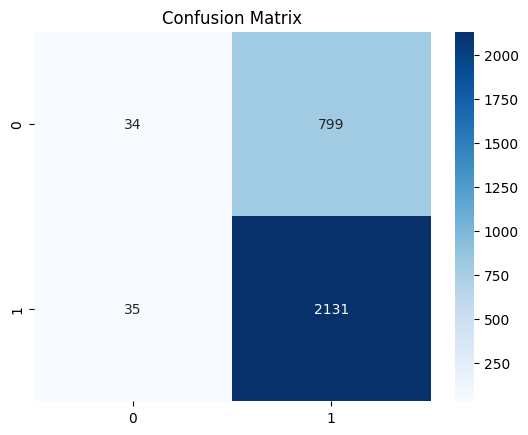

In [13]:
cols_to_drop = ['PetID', 'AdoptionSpeed','Description','Name','RescuerID','label']
train_binary = train.copy()
train_binary['label'] = train_binary['AdoptionSpeed'].apply(lambda x: '0' if x == 4 else '1' if x < 4 else None)
X = train_binary.drop(cols_to_drop,axis=1)
y = train_binary['label']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create an SVM classifier
svm_classifier = SVC(kernel='linear', C=1)  # OvR (One-vs-Rest)

# Train the classifier
svm_classifier.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = svm_classifier.predict(X_test_scaled)
x_pred = svm_classifier.predict(X_train_scaled)

# Evaluate the model
test_accuracy = accuracy_score(y_test, y_pred)
train_accuracy = accuracy_score(y_train, x_pred)
print("Random Forest train accuracy: {:.2f}%".format(train_accuracy * 100))
print("Random Forest test accuracy: {:.2f}%".format(test_accuracy * 100))

# Classification report and confusion matrix
print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()




Random Forest train accuracy: 71.95%
Random Forest test accuracy: 72.22%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       833
           1       0.72      1.00      0.84      2166

    accuracy                           0.72      2999
   macro avg       0.36      0.50      0.42      2999
weighted avg       0.52      0.72      0.61      2999



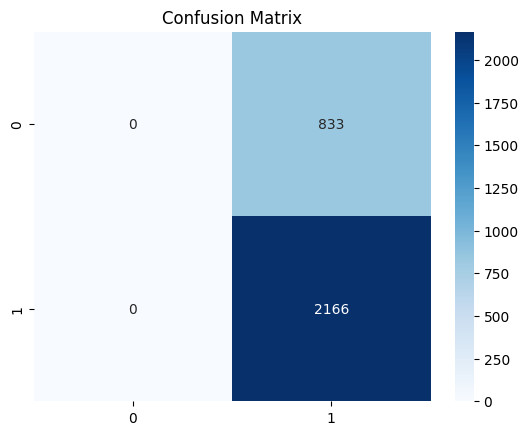

In [67]:
cols_to_drop = ['PetID', 'AdoptionSpeed','Description','Name','RescuerID','label']
train_binary = train.copy()
train_binary['label'] = train_binary['AdoptionSpeed'].apply(lambda x: '0' if x == 4 else '1' if x < 4 else None)
X = train_binary.drop(cols_to_drop,axis=1)
y = train_binary['label']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create an SVM classifier
svm_classifier = SVC(kernel='linear', C=1)  # OvR (One-vs-Rest)

# Train the classifier
svm_classifier.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = svm_classifier.predict(X_test_scaled)
x_pred = svm_classifier.predict(X_train_scaled)

# Evaluate the model
test_accuracy = accuracy_score(y_test, y_pred)
train_accuracy = accuracy_score(y_train, x_pred)
print("SVM train accuracy: {:.2f}%".format(train_accuracy * 100))
print("SVM test accuracy: {:.2f}%".format(test_accuracy * 100))

# Classification report and confusion matrix
print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()




Random Forest train accuracy: 71.95%
Random Forest test accuracy: 72.22%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       833
           1       0.72      1.00      0.84      2166

    accuracy                           0.72      2999
   macro avg       0.36      0.50      0.42      2999
weighted avg       0.52      0.72      0.61      2999



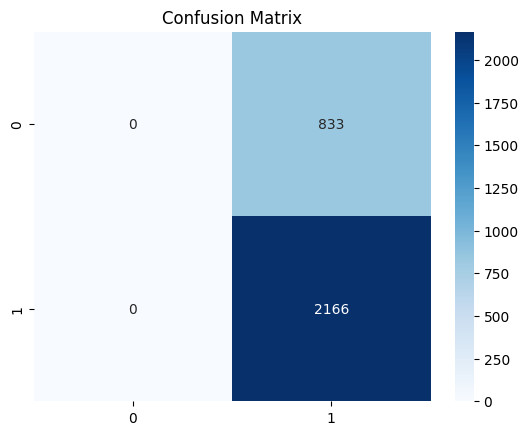

In [12]:
svm_() #fv 3

Random Forest train accuracy: 71.98%
Random Forest test accuracy: 72.22%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       833
           1       0.72      1.00      0.84      2166

    accuracy                           0.72      2999
   macro avg       0.36      0.50      0.42      2999
weighted avg       0.52      0.72      0.61      2999



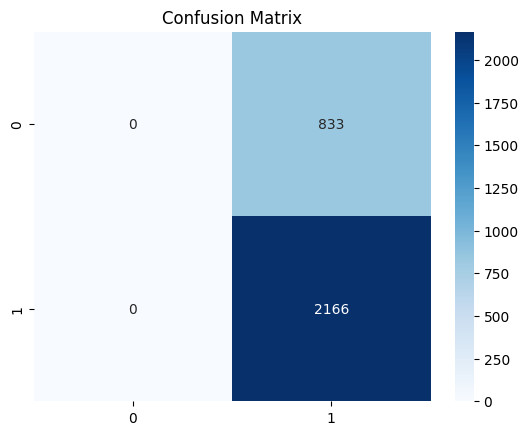

In [56]:
svm_(train) #fv 2.5

## Random Forest 

In [18]:
def gscv_rf_we_bc(train):   
    cols_to_drop = ['PetID', 'AdoptionSpeed','Description','Name','RescuerID','label']
    train_binary = train.copy()
    train_binary['label'] = train_binary['AdoptionSpeed'].apply(lambda x: '0' if x == 4 else '1' if x < 4 else None)
    X = train_binary.drop(cols_to_drop,axis=1)
    y = train_binary['label']
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

#     numeric_features = ['Age','Fee','VideoAmt','PhotoAmt','Quantity']
    numerical_columns = train.select_dtypes(include=['number']).drop(['AdoptionSpeed'],axis = 1)
    numeric_features = list(numerical_columns.columns)
    categorical_features = ['Type', 'Color1', 'Color2', 'Gender', 'MaturitySize', 
                        'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Breed1','Gender']

    numeric_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())])


    categorical_transformer = Pipeline(steps=[

        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

    # Fitting the preprocessor on the training data
    preprocessor.fit(X_train)

    # pipeline for preprocessor and randomforest
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', 
                       RandomForestClassifier()
                         )])  



    # # Create the parameter grid based on the results of random search 
    param_grid = {
        'classifier__bootstrap': [True],  # Method of selecting samples for training each tree
        'classifier__max_depth': [120, 140, 150, 160],  # Maximum number of levels in tree
        'classifier__min_samples_leaf': [3, 4, 5],  # Minimum number of samples required at each leaf node
        'classifier__min_samples_split': [8, 10, 12],  # Minimum number of samples required to split a node
        'classifier__n_estimators': [100, 200, 300]  # Number of trees in random forest
    }

 


    # Instantiate the grid search model
    grid = GridSearchCV(estimator = pipeline, param_grid = param_grid, 
                              cv = 3, n_jobs = -1, verbose = 2)#scoring='accuracy'
    grid.fit(X_train, y_train);
    grid.best_params_

    model = grid.best_estimator_
    y_model = model.predict(X_valid)
    y_model_train = model.predict(X_train)

    # accuracy score
    train_accuracy_rf = model.score(X_train, y_train)
    test_accuracy_rf = model.score(X_valid, y_valid)
    print("Random Forest train accuracy: {:.2f}%".format(train_accuracy_rf * 100))
    print("Random Forest test accuracy: {:.2f}%".format(test_accuracy_rf * 100))



In [19]:
gscv_rf_we_bc(train) #fv3

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Random Forest train accuracy: 94.78%
Random Forest test accuracy: 75.43%


In [57]:
gscv_rf_we_bc(train) #fv2.5

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Random Forest train accuracy: 87.65%
Random Forest test accuracy: 76.29%


## Logistic Regression

Logistic Regression train accuracy: 72.42%
Logistic Regression test accuracy: 72.72%
              precision    recall  f1-score   support

           0       0.56      0.08      0.15       833
           1       0.73      0.97      0.84      2166

    accuracy                           0.73      2999
   macro avg       0.65      0.53      0.49      2999
weighted avg       0.69      0.73      0.65      2999



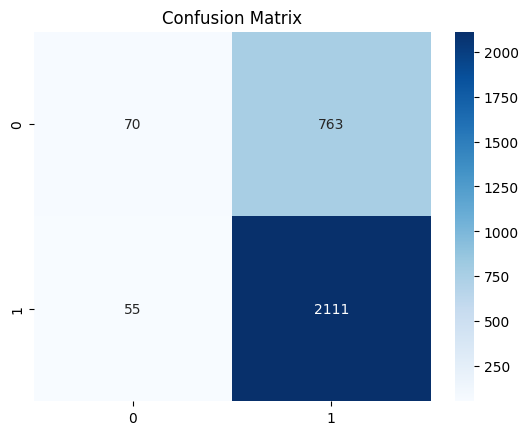

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

def logistic_regression(train):
    
    cols_to_drop = ['PetID', 'AdoptionSpeed','Description','Name','RescuerID','label']
    train_binary = train.copy()
    train_binary['label'] = train_binary['AdoptionSpeed'].apply(lambda x: '0' if x == 4 else '1' if x < 4 else None)
    X = train_binary.drop(cols_to_drop,axis=1)
    y = train_binary['label']    
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Create a Logistic Regression classifier
    lr_classifier = LogisticRegression(multi_class='ovr')  # OvR (One-vs-Rest)

    # Train the classifier
    lr_classifier.fit(X_train_scaled, y_train)

    # Make predictions on the test set
    y_pred = lr_classifier.predict(X_test_scaled)
    x_pred = lr_classifier.predict(X_train_scaled)

    # Evaluate the model
    test_accuracy = accuracy_score(y_test, y_pred)
    train_accuracy = accuracy_score(y_train, x_pred)
    print("Logistic Regression train accuracy: {:.2f}%".format(train_accuracy * 100))
    print("Logistic Regression test accuracy: {:.2f}%".format(test_accuracy * 100))

    # Classification report and confusion matrix
    print(classification_report(y_test, y_pred))
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

logistic_regression(train)


Logistic Regression train accuracy: 72.42%
Logistic Regression test accuracy: 72.72%
              precision    recall  f1-score   support

           0       0.56      0.08      0.15       833
           1       0.73      0.97      0.84      2166

    accuracy                           0.73      2999
   macro avg       0.65      0.53      0.49      2999
weighted avg       0.69      0.73      0.65      2999



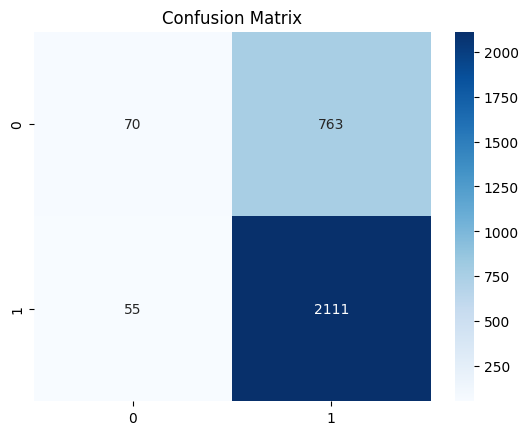

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

def logistic_regression_eval_mc(train):
    
    cols_to_drop = ['PetID', 'AdoptionSpeed','Description','Name','RescuerID','label']
    train_binary = train.copy()
    train_binary['label'] = train_binary['AdoptionSpeed'].apply(lambda x: '0' if x == 4 else '1' if x < 4 else None)
    X = train_binary#.drop(cols_to_drop,axis=1)
    y = train_binary['label']
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
    X_valid_temp = X_train.copy()
    X_train = X_train.drop(cols_to_drop,axis=1)
    X_valid = X_valid.drop(cols_to_drop,axis=1)

    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)

    # Create a Logistic Regression classifier
    lr_classifier = LogisticRegression(multi_class='ovr')  # OvR (One-vs-Rest)

    # Train the classifier
    lr_classifier.fit(X_train_scaled, y_train)

    # Make predictions on the test set
    y_pred = lr_classifier.predict(X_valid_scaled)
    x_pred = lr_classifier.predict(X_train_scaled)

    # Evaluate the model
    test_accuracy = accuracy_score(y_valid, y_pred)
    train_accuracy = accuracy_score(y_train, x_pred)
    print("Logistic Regression train accuracy: {:.2f}%".format(train_accuracy * 100))
    print("Logistic Regression test accuracy: {:.2f}%".format(test_accuracy * 100))

    # Classification report and confusion matrix
    print(classification_report(y_valid, y_pred))
    conf_matrix = confusion_matrix(y_valid, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()

logistic_regression_eval_mc(train)


In [107]:


cols_to_drop = ['PetID', 'AdoptionSpeed','Description','Name','RescuerID','label']
train_binary = train.copy()
train_binary['label'] = train_binary['AdoptionSpeed'].apply(lambda x: '0' if x == 4 else '1' if x < 4 else None)
X = train_binary#.drop(cols_to_drop,axis=1)
y = train_binary['label']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
X_valid_temp = X_valid.copy()
X_train = X_train.drop(cols_to_drop,axis=1)
X_valid = X_valid.drop(cols_to_drop,axis=1)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# Create a Logistic Regression classifier
lr_classifier = LogisticRegression(multi_class='ovr')  # OvR (One-vs-Rest)

# Train the classifier
lr_classifier.fit(X_train_scaled, y_train)

# Make predictions on the test set 
# y_pred = lr_classifier.predict(X_valid_scaled)
# x_pred = lr_classifier.predict(X_train_scaled)
y_pred = lr_classifier.predict_proba(X_valid_scaled)
x_pred = lr_classifier.predict_proba(X_train_scaled)

# Evaluate the model
# test_accuracy = accuracy_score(y_valid, y_pred)
# train_accuracy = accuracy_score(y_train, x_pred)
# print("Logistic Regression train accuracy: {:.2f}%".format(train_accuracy * 100))
# print("Logistic Regression test accuracy: {:.2f}%".format(test_accuracy * 100))

# # Classification report and confusion matrix
# print(classification_report(y_valid, y_pred))
# conf_matrix = confusion_matrix(y_valid, y_pred)
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
# plt.title('Confusion Matrix')
# plt.show()





In [77]:
y_pred[:5], X_valid_temp['AdoptionSpeed'][:5]

(array([[0.50892663, 0.49107337],
        [0.19338288, 0.80661712],
        [0.32218077, 0.67781923],
        [0.35763673, 0.64236327],
        [0.27945189, 0.72054811]]),
 6786     3
 9837     3
 7688     3
 6556     2
 11322    4
 Name: AdoptionSpeed, dtype: int64)

(2999,)

In [87]:
y_pred[0].max(), 

(2999, (2,))

In [90]:
y_pred.shape

(2999, 2)

In [118]:
# #unnecessary
# max_values = np.max(y_pred, axis=1)
# max_values[:5]
# X_valid_temp['LRProb'] = max_values
# X_valid_temp['LRProb'][:5],X_valid_temp['AdoptionSpeed'][:5]

# # X_valid_temp.shape

In [117]:
y_pred_0 = np.delete(y_pred, 1, axis=1)
y_pred_0

array([[0.50892663],
       [0.19338288],
       [0.32218077],
       ...,
       [0.35642678],
       [0.26520528],
       [0.22497444]])

In [120]:
y_pred_1 = np.delete(y_pred, 0, axis=1)
y_pred_1.shape

(2999, 1)

In [123]:
y_pred_0 = np.delete(y_pred, 1, axis=1)
X_valid_temp['LRProb0'] = y_pred_0.flatten()
X_valid_temp['LRProb1'] = y_pred_1.flatten()

X_valid_temp['LRProb'][:5],X_valid_temp['AdoptionSpeed'][:5]



(13408    0.508927
 6472     0.806617
 9967     0.677819
 862      0.642363
 5967     0.720548
 Name: LRProb, dtype: float64,
 13408    4
 6472     2
 9967     4
 862      2
 5967     2
 Name: AdoptionSpeed, dtype: int64)

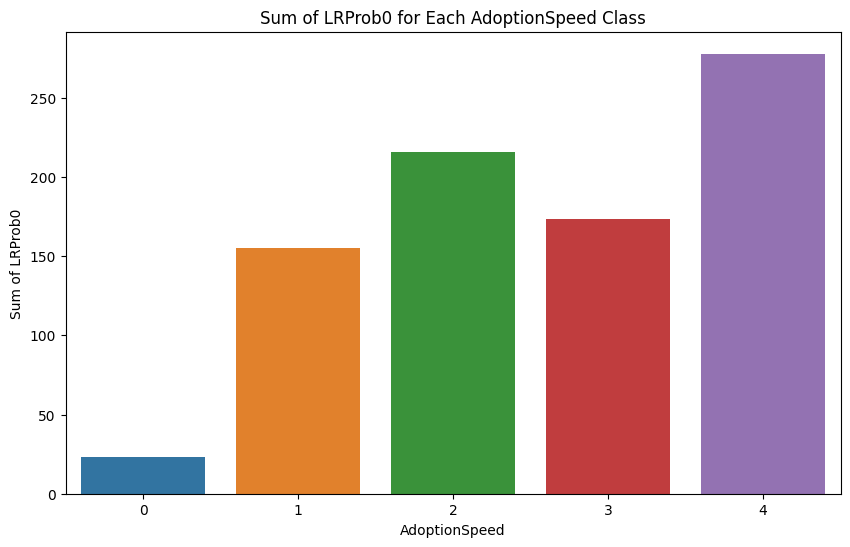

In [124]:
# Group by AdoptionSpeed and calculate the sum of LRProb0 for each class
grouped_df = X_valid_temp.groupby('AdoptionSpeed')['LRProb0'].sum().reset_index()

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped_df, x='AdoptionSpeed', y='LRProb0')
plt.title('Sum of LRProb0 for Each AdoptionSpeed Class')
plt.xlabel('AdoptionSpeed')
plt.ylabel('Sum of LRProb0')
plt.show()

In [125]:
grouped_df

AdoptionSpeed     LRProb0
0              0   23.006166
1              1  155.135995
2              2  215.899366
3              3  173.342327
4              4  277.889199

In [135]:
ba =(y_train == class_label else ).astype(int)
(ba==0).sum()

11994

In [126]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assuming X_train, y_train are your original features and labels
# Train binary classifiers
binary_classifiers = {}
unique_classes = [0,1,2,3,4]
for class_label in unique_classes:
    # Create binary labels for the current class vs. rest
    binary_labels = (y_train == class_label).astype(int)
    
    # Train a binary classifier (e.g., Logistic Regression)
    binary_classifier = LogisticRegression()
    binary_classifier.fit(X_train, binary_labels)
    
    # Save the binary classifier
    binary_classifiers[class_label] = binary_classifier

# Generate new features based on binary classifiers
binary_features = {}
for class_label, binary_classifier in binary_classifiers.items():
    # Use the predicted probabilities as a new feature
    binary_features[class_label] = binary_classifier.predict_proba(X_train)[:, 1]

# Combine new features with the original features
X_train_combined = np.column_stack((X_train, *[binary_features[class_label] for class_label in unique_classes]))

# Train a final classifier (e.g., Logistic Regression) using the combined features
final_classifier = RandomForestClassifier()
final_classifier.fit(X_train_combined, y_train)

# Similar steps can be applied to the validation set for evaluation


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Assuming your data and logistic_regression_eval_mc function are defined above

def plot_prob_distribution(y_pred_probs, true_labels):
    # Create a DataFrame combining predicted probabilities and true labels
    pred_df = pd.DataFrame(y_pred_probs, columns=[f'Probability_{class_label}' for class_label in lr_classifier.classes_])
    pred_df['AdoptionSpeed'] = true_labels

    # Group by true labels and calculate the sum of predicted probabilities
    grouped_df = pred_df.groupby('AdoptionSpeed').sum()

    # Plot the distribution
    plt.figure(figsize=(10, 6))
    sns.barplot(data=grouped_df, x=grouped_df.index, y=grouped_df.sum(axis=1))
    plt.title('Sum of Predicted Probabilities by True Label')
    plt.xlabel('AdoptionSpeed')
    plt.ylabel('Sum of Predicted Probabilities')
    plt.show()

# Assuming X_valid_temp contains the necessary features for prediction
X_valid_temp = X_valid_temp.drop(cols_to_drop, axis=1)  # Drop unnecessary columns

# Standardize the features
X_valid_temp_scaled = scaler.transform(X_valid_temp)

# Make predictions on the validation set
y_pred_probs = lr_classifier.predict_proba(X_valid_temp_scaled)

# Extract the true labels from X_valid_temp
true_labels = X_valid_temp['AdoptionSpeed']

# Call the function to plot the distribution
plot_prob_distribution(y_pred_probs, true_labels)


In [ ]:

from sklearn.linear_model import LogisticRegression


# Generate a sample dataset
np.random.seed(42)

cols_to_drop = ['PetID', 'AdoptionSpeed','Description','Name','RescuerID','label']
train_binary = train.copy()
train_binary['label'] = train_binary['AdoptionSpeed'].apply(lambda x: '0' if x == 4 else '1' if x < 4 else None)
X = train_binary#.drop(cols_to_drop,axis=1)
y = train_binary['label']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_temp = X_train.copy()
X_train = train_binary.drop(cols_to_drop,axis=1)
X_valid = train_binary.drop(cols_to_drop,axis=1)


# Standardize the features (important for SVM)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

# Train SVM model
svm_model = SVC(probability=True, kernel='linear')
svm_model.fit(X_train_scaled, y_train)

# Train Logistic Regression model
lr_model = LogisticRegression(multi_class='line')  # 'ovr' for multi-class
lr_model.fit(X_train_scaled, y_train)

# Get prediction probabilities
svm_probabilities = svm_model.predict_proba(X_valid_scaled)
lr_probabilities = lr_model.predict_proba(X_valid_scaled)

# accuracy score
train_accuracy_rf = model.score(X_train_scaled, y_train)
test_accuracy_rf = model.score(X_valid, y_valid)
print("Random Forest train accuracy: {:.2f}%".format(train_accuracy_rf * 100))
print("Random Forest test accuracy: {:.2f}%".format(test_accuracy_rf * 100))

 # accuracy score
train_accuracy_rf = model.score(X_train, y_train)
test_accuracy_rf = model.score(X_valid, y_valid)
print("Random Forest train accuracy: {:.2f}%".format(train_accuracy_rf * 100))
print("Random Forest test accuracy: {:.2f}%".format(test_accuracy_rf * 100))
    
# Check the distribution against the existing categorical column
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# SVM
sns.histplot(data=pd.DataFrame(svm_probabilities, columns=data['AdoptionSpeed'].unique()), kde=True, ax=axes[0])
axes[0].set_title('SVM Probability Distribution')
axes[0].legend(title='Adoption Speed')

# Logistic Regression
sns.histplot(data=pd.DataFrame(lr_probabilities, columns=data['AdoptionSpeed'].unique()), kde=True, ax=axes[1])
axes[1].set_title('Logistic Regression Probability Distribution')
axes[1].legend(title='Adoption Speed')

plt.show()


In [106]:
cols_to_drop = ['PetID', 'AdoptionSpeed','Description','Name','RescuerID']
X = train.drop(cols_to_drop, axis=1)
y = train['AdoptionSpeed']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


In [107]:
# X.head()
X['polarity']

0        1.303571e-01
1        1.000000e-01
2        2.619048e-01
3        3.411458e-01
4        4.000000e-01
5        0.000000e+00
6        2.500000e-01
7        1.250000e-01
8        3.888889e-02
9        2.137500e-01
10       1.388889e-01
11       6.579832e-02
12       4.083333e-01
13       3.175000e-01
14       1.666667e-01
15       5.020833e-01
16       4.375000e-01
17       2.133333e-01
18       3.005952e-01
19       1.357353e-01
20       4.277778e-01
21       5.000000e-01
22       0.000000e+00
23       1.916667e-01
24       7.500000e-01
25       1.603968e-01
26       3.500000e-01
27       5.000000e-01
28       2.888889e-01
29       5.000000e-02
30       2.428571e-01
31       0.000000e+00
32       1.209716e-01
33       3.444444e-01
34       0.000000e+00
35       5.000000e-01
36       5.000000e-01
37       6.250000e-01
38       2.291667e-01
39       5.020833e-01
40      -1.250000e-02
41       3.166667e-01
42      -5.416667e-02
43       1.180556e-01
44       3.500000e-01
45       1

In [34]:
X.isnull().sum()

Type                  0
Age                   0
Breed1                0
Breed2                0
Gender                0
Color1                0
Color2                0
Color3                0
MaturitySize          0
FurLength             0
Vaccinated            0
Dewormed              0
Sterilized            0
Health                0
Quantity              0
Fee                   0
State                 0
VideoAmt              0
PhotoAmt              0
Description_Length    0
HasName               0
polarity              0
subjectivity          0
dtype: int64

In [35]:
# Using RandomForestClassifier as an example
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

Accuracy: 0.43
              precision    recall  f1-score   support

           0       0.67      0.07      0.12        92
           1       0.39      0.37      0.38       627
           2       0.38      0.40      0.39       806
           3       0.40      0.25      0.31       641
           4       0.51      0.68      0.58       833

    accuracy                           0.43      2999
   macro avg       0.47      0.35      0.36      2999
weighted avg       0.43      0.43      0.42      2999



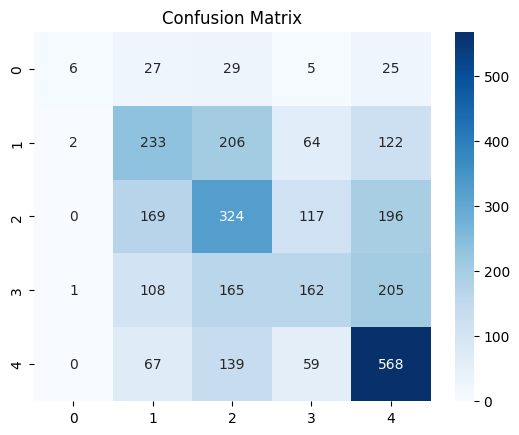

In [36]:
# Predictions on the validation set
y_pred = model.predict(X_valid)

# Evaluate the model
accuracy = accuracy_score(y_valid, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Classification report and confusion matrix
print(classification_report(y_valid, y_pred))
conf_matrix = confusion_matrix(y_valid, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


In [37]:
def plot_feature_importance(importance, names, model_type, top_k=None):
    # creating a df from feature importance and feature names
    fi_df = pd.DataFrame({'feature_names': names, 'feature_importance': importance})

    # sorting the df by feature importance in descending order
    fi_df = fi_df.sort_values(by='feature_importance', ascending=False)

    # Select the top k features if specified
    if top_k is not None:
        fi_df = fi_df.head(top_k)

    # creating a horizontal bar plot for feature importance
    plt.figure(figsize=(10, 8))
    sns.barplot(x='feature_importance', y='feature_names', data=fi_df, palette="viridis")

    # adding chart labels and title
    plt.title(f'{model_type} Feature Importance' + (f' - Top {top_k}' if top_k is not None else ''))
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

    plt.show()

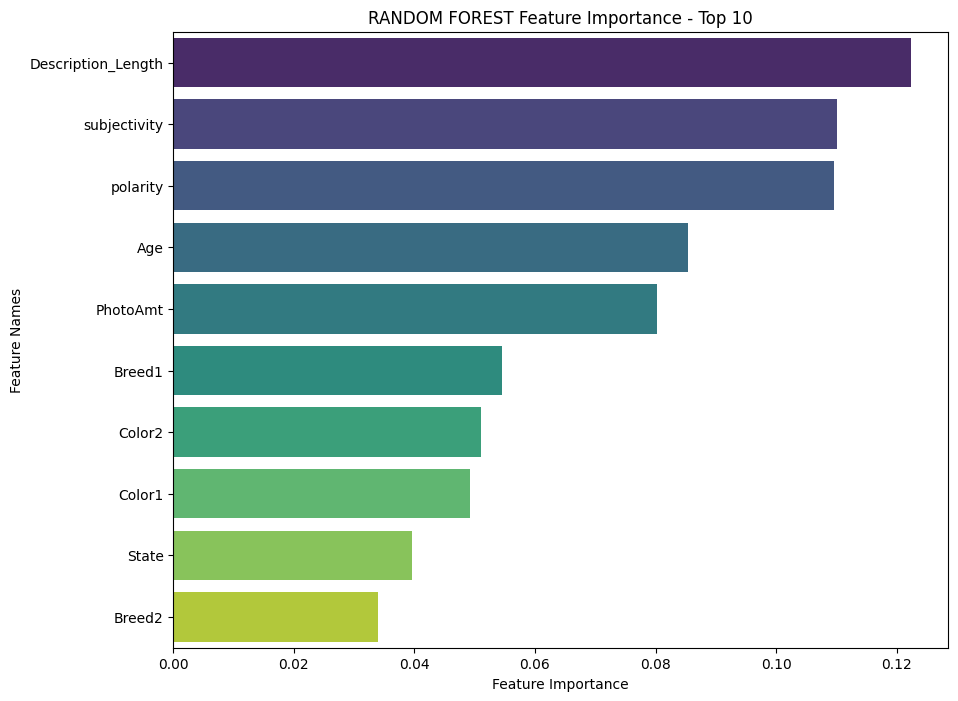

In [38]:
columns = X.columns
plot_feature_importance(model.feature_importances_,columns[:],'RANDOM FOREST',10)


In [80]:
train.head()

Name  Age  Breed1  Breed2  MaturitySize  FurLength  Vaccinated  \
0       Nibble    3     299       0             1          1           2   
1  No Name Yet    1     265       0             2          2           3   
2       Brisco    1     307       0             2          2           1   
3         Miko    4     307       0             2          1           1   
4       Hunter    1     307       0             2          1           2   

   Dewormed  Sterilized  Health  ...  Color2_4  Color2_5  Color2_6 Color2_7  \
0         2           2       1  ...     False     False     False     True   
1         3           3       1  ...     False     False     False    False   
2         1           2       1  ...     False     False     False     True   
3         1           2       1  ...     False     False     False    False   
4         2           2       1  ...     False     False     False    False   

   Color3_0 Color3_3 Color3_4  Color3_5  Color3_6  Color3_7  
0      True    False    False     False     False     False  
1      True    False    False     False     False     False  
2      True    False    False     False     False     False  
3      True    False    False     False     False     False  
4      True    False    False     False     False     False  

[5 rows x 46 columns]

In [ ]:
categorical_cols = ['Type', 'Color1', 'Color2', 'Gender', 'MaturitySize', 'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Breed1']


In [ ]:
# encode categorical data and create pipeline for automating the process for new data
numeric_features = ['Age','Fee','VideoAmt','PhotoAmt','Quantity']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])


categorical_cols = ['Type', 'Color1', 'Color2', 'Gender', 'MaturitySize', 
                    'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Breed1','Gender']

categorical_transformer = Pipeline(steps=[
    
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [66]:
# # encode categorical data and create pipeline for automating the process for new data
# numeric_features = ['Age','Fee','VideoAmt','PhotoAmt','Quantity']
# numeric_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='median')),
#     ('scaler', StandardScaler())])

# categorical_features = ['Type','Gender','MaturitySize','FurLength','Vaccinated',
#                         'Dewormed','Sterilized','Health','Breed1','Color1']
# # categorical_features = ['MaturitySize','FurLength','Vaccinated',
# #                         'Dewormed','Sterilized','Health','Breed1','Breed2']

# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numeric_transformer, numeric_features),
#         ('cat', categorical_transformer, categorical_features)])

In [72]:
numeric_features = ['Age','Fee','VideoAmt','PhotoAmt','Quantity','subjectivity','polarity']
    
categorical_features = ['Type', 'Color1', 'Color2', 'Gender', 'MaturitySize', 
                    'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Breed1','Gender']

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])


categorical_transformer = Pipeline(steps=[

    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [71]:
X['subjectivity']


0        0.407143
1        0.400000
2        0.542857
3        0.437500
4        0.743750
           ...   
14988    0.425000
14989    0.287500
14990    0.616667
14991    0.650000
14992    0.316667
Name: subjectivity, Length: 14993, dtype: float64

In [107]:
train.columns

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed',
       'Description_Length', 'HasName'],
      dtype='object')

In [81]:
'Gender' in train.columns

False

In [73]:
cols_to_drop = ['PetID', 'AdoptionSpeed','Description','Name','RescuerID']
X = train.drop(cols_to_drop, axis=1)
y = train['AdoptionSpeed']
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=0)


In [74]:
# confirm split
print('Training Features Shape:', Xtrain.shape)
print('Training Labels Shape:', ytrain.shape)
print('Testing Features Shape:', Xtest.shape)
print('Testing Labels Shape:', ytest.shape)

Training Features Shape: (11244, 23)
Training Labels Shape: (11244,)
Testing Features Shape: (3749, 23)
Testing Labels Shape: (3749,)


In [75]:
loaded_best_params = {'bootstrap': True,
 'max_depth': 150,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 200}

In [82]:
model_1 = Pipeline(steps=[('preprocessor', preprocessor),
                  ('classifier', 
                   RandomForestClassifier(n_jobs=-1, n_estimators=200)
                     )])  
model_1.fit(Xtrain,ytrain)

# make predictions on test data
y_model_randomforest = model_1.predict(Xtest)

# accuracy score
train_accuracy_rf = model_1.score(Xtrain, ytrain)
test_accuracy_rf = model_1.score(Xtest, ytest)
print("Random Forest train accuracy: {:.2f}%".format(train_accuracy_rf * 100))
print("Random Forest test accuracy: {:.2f}%".format(test_accuracy_rf * 100))

Random Forest train accuracy: 99.58%
Random Forest test accuracy: 38.68%


In [123]:
model_1[1]

RandomForestClassifier(n_estimators=300, n_jobs=-1)

In [118]:
model

RandomForestClassifier(random_state=42)

In [131]:
# instantiate model
model_randomforest = RandomForestClassifier(n_estimators=150)
model_randomforest.fit(Xtrain,ytrain)

# make predictions on test data
y_model_randomforest = model_randomforest.predict(Xtest)

# accuracy score
train_accuracy_rf = model_randomforest.score(Xtrain, ytrain)
test_accuracy_rf = model_randomforest.score(Xtest, ytest)
print("Random Forest train accuracy: {:.2f}%".format(train_accuracy_rf * 100))
print("Random Forest test accuracy: {:.2f}%".format(test_accuracy_rf * 100))

Random Forest train accuracy: 99.76%
Random Forest test accuracy: 42.22%


In [40]:
cols_to_drop = ['PetID', 'AdoptionSpeed','Description','Name','RescuerID']
X = train.drop(cols_to_drop, axis=1)
y = train['AdoptionSpeed']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


In [293]:
import joblib

model_save_path='Models/random_forest_model_.joblib'.format(datetime.now().replace(second=0, microsecond=0))
joblib.dump(grid.best_estimator_, model_save_path)

['Models/random_forest_model_.joblib']

In [294]:
model = joblib.load(model_save_path)
print(f"Random Forest model loaded from {model_save_path}")

Random Forest model loaded from Models/random_forest_model_.joblib


In [295]:
model = grid.best_estimator_
y_model = model.predict(Xtest)
y_model_train = model.predict(Xtrain)

# accuracy
print("Random Forest Train Accuracy: ", accuracy_score(ytrain, y_model_train))
print("Random Forest Test Accuracy: ", accuracy_score(ytest, y_model))

Random Forest Train Accuracy:  0.8469405905371754
Random Forest Test Accuracy:  0.8482261936516404


In [44]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],               # Method of selecting samples for training each tree
    'max_depth': [120, 140, 150, 160], # Maximum number of levels in tree
    #'max_features': [3, 4, 5],        # Number of features to consider at every split
    'min_samples_leaf': [3, 4, 5],     # Minimum number of samples required at each leaf node
    'min_samples_split': [8, 10, 12],  # Minimum number of samples required to split a node
    'n_estimators': [100, 200, 300]    # Number of trees in random forest
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid.fit(X, y);
grid.best_params_

Fitting 3 folds for each of 108 candidates, totalling 324 fits


{'bootstrap': True,
 'max_depth': 150,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 300}

In [45]:
model = grid.best_estimator_
y_model = model.predict(Xtest)
y_model_train = model.predict(Xtrain)

# accuracy
print("Random Forest Train Accuracy: ", accuracy_score(ytrain, y_model_train))
print("Random Forest Test Accuracy: ", accuracy_score(ytest, y_model))

Random Forest Train Accuracy:  0.9037709000355745
Random Forest Test Accuracy:  0.8997065884235796


In [14]:

model_path = 'Models'

def run_rf(X, y, grid_cv, model_save_path):

    try:
        if not os.path.exists(model_path):
            os.makedirs(model_path)
            print('created')
        else :
            print('exist')
            model_exist = os.listdir(model_path)
        
            
        if not model_save_path:
            model_save_path='{}/random_forest_model.joblib'.format(model_path) # add versioning here
        
        if grid_cv:
            if not model_exist:
                print(model_save_path)
                

            else:
                print('Found a model\n')
                # Loading the pre-trained model from file
                model = joblib.load(model_save_path)
                print(f"Random Forest model loaded from {model_save_path}")
                
                
#         eval_rf(model, Xtrain, Xtest, ytrain, ytest)
#         return model

    except Exception as e:
        print('Exception :',e)

[]

In [15]:
run_rf(None, None, True, None)

exist
Models/random_forest_model.joblib


# Make it Binary classification


In [4]:

cols_to_drop = ['PetID', 'AdoptionSpeed','Description','Name','RescuerID','label']
train_binary = train.copy()
train_binary['label'] = train_binary['AdoptionSpeed'].apply(lambda x: '0' if x == 4 else '1' if x < 4 else None)
X = train_binary.drop(cols_to_drop,axis=1)
y = train_binary['label']

Random Forest train accuracy: 71.73%
Random Forest test accuracy: 71.86%
R2 score : -40.0
              precision    recall  f1-score   support

           0       0.44      0.05      0.09       833
           1       0.73      0.98      0.83      2166

    accuracy                           0.72      2999
   macro avg       0.58      0.51      0.46      2999
weighted avg       0.65      0.72      0.63      2999



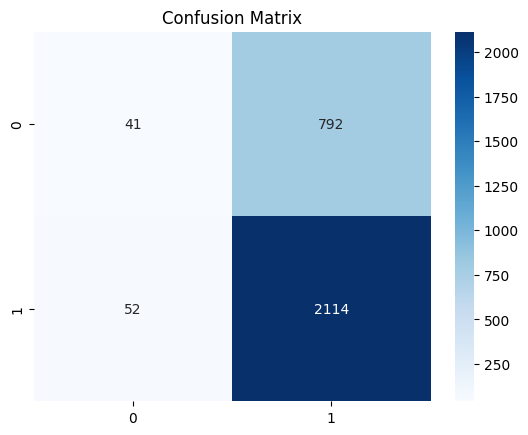

In [69]:
cols_to_drop = ['PetID', 'AdoptionSpeed','Description','Name','RescuerID','label']
train_binary = train.copy()
train_binary['label'] = train_binary['AdoptionSpeed'].apply(lambda x: '0' if x == 4 else '1' if x < 4 else None)
X = train_binary.drop(cols_to_drop,axis=1)
y = train_binary['label']
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an SVM classifier
svm_classifier = SVC(kernel='linear', C=1)  # OvR (One-vs-Rest)

# Train the classifier
svm_classifier.fit(X, y)

# Make predictions on the test set
y_pred = svm_classifier.predict(X_test)
x_pred = svm_classifier.predict(X_train)
score = r2_score(y_test, y_pred)

# Evaluate the model
test_accuracy = accuracy_score(y_test, y_pred)
train_accuracy = accuracy_score(y_train, x_pred)
print("Random Forest train accuracy: {:.2f}%".format(train_accuracy * 100))
print("Random Forest test accuracy: {:.2f}%".format(test_accuracy * 100))
print('R2 score :',round(score,2)*100)

# Classification report and confusion matrix
print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()




Confusion Matrix:
[[  34  799]
 [  35 2131]]

Accuracy: 72.19%


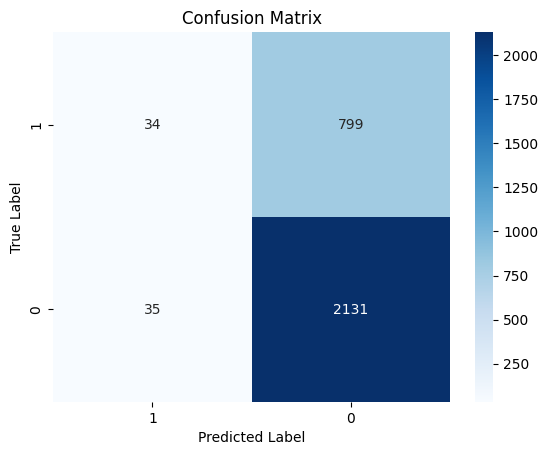

In [157]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an SVM classifier
svm_classifier = SVC(kernel='linear', C=1)  # OvR (One-vs-Rest)

# Train the classifier
svm_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_classifier.predict(X_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy * 100:.2f}%")

labels = train_binary['label'].unique()

# Visualize the confusion matrix using a heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()




## Random Forest

In [101]:
# cols_to_drop = ['PetID', 'AdoptionSpeed','Description','Name','RescuerID']
# X = train.drop(cols_to_drop, axis=1)
# y = train['AdoptionSpeed']
# Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=0)


In [104]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: label, dtype: object

In [105]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],               # Method of selecting samples for training each tree
    'max_depth': [120, 140, 150, 160], # Maximum number of levels in tree
    #'max_features': [3, 4, 5],        # Number of features to consider at every split
    'min_samples_leaf': [3, 4, 5],     # Minimum number of samples required at each leaf node
    'min_samples_split': [8, 10, 12],  # Minimum number of samples required to split a node
    'n_estimators': [100, 200, 300]    # Number of trees in random forest
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid.fit(X, y);
grid.best_params_

Fitting 3 folds for each of 108 candidates, totalling 324 fits


{'bootstrap': True,
 'max_depth': 120,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 300}

In [247]:
grid.best_params_

{'bootstrap': True,
 'max_depth': 120,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 300}

In [251]:
loaded_best_params = {'bootstrap': True,
 'max_depth': 120,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 200}

In [255]:
cols_to_drop = ['PetID', 'AdoptionSpeed','Description','Name','RescuerID']
X = train.drop(cols_to_drop, axis=1)
y = train['AdoptionSpeed']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)


# instantiate model
model_randomforest = RandomForestClassifier(**loaded_best_params)
model_randomforest.fit(Xtrain,ytrain)

# make predictions on test data
y_model_randomforest = model_randomforest.predict(Xtest)

# accuracy score
train_accuracy_rf = model_randomforest.score(Xtrain, ytrain)
test_accuracy_rf = model_randomforest.score(Xtest, ytest)
print("Random Forest train accuracy: {:.2f}%".format(train_accuracy_rf * 100))
print("Random Forest test accuracy: {:.2f}%".format(test_accuracy_rf * 100))

Random Forest train accuracy: 85.43%
Random Forest test accuracy: 42.01%


In [256]:
model = grid.best_estimator_
y_model = model.predict(Xtest)
y_model_train = model.predict(Xtrain)

# accuracy
print("Random Forest Train Accuracy: ", accuracy_score(ytrain, y_model_train))
print("Random Forest Test Accuracy: ", accuracy_score(ytest, y_model))

Random Forest Train Accuracy:  0.8500533617929562
Random Forest Test Accuracy:  0.8516937850093358


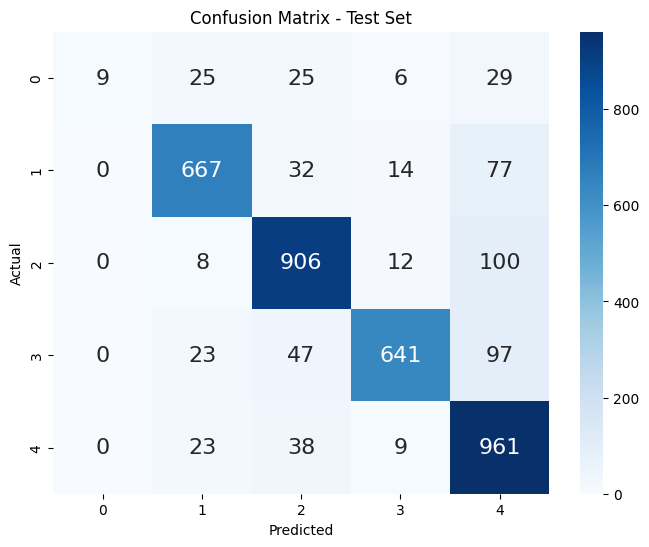

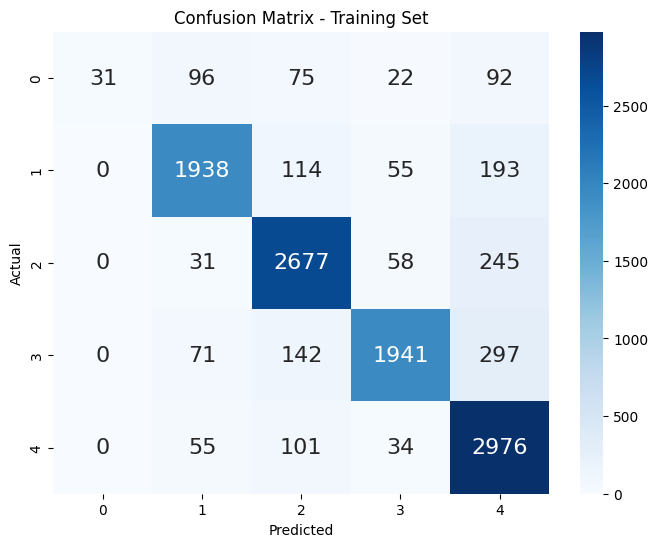

In [191]:
# Confusion matrix for test set
conf_matrix_test = confusion_matrix(ytest, y_model)

# Confusion matrix for training set
conf_matrix_train = confusion_matrix(ytrain, y_model_train)

# Plotting the confusion matrix for test set
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plotting the confusion matrix for training set
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.title('Confusion Matrix - Training Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [244]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Assuming you have a DataFrame X with your features and y as the target variable

# Step 1: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Standardize the data (important for PCA)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Run PCA to retain 98% of the variability
pca = PCA(n_components=0.99)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# # Step 4: Train Random Forest on the reduced dataset
rf_classifier = RandomForestClassifier()
# rf_classifier.fit(X_train_pca, y_train)

# # Step 5: Make predictions on the test set
# y_pred = rf_classifier.predict(X_test_pca)

# # Step 6: Evaluate the performance
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy on the test set: {accuracy * 100:.2f}%")


In [239]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],               # Method of selecting samples for training each tree
    'max_depth': [120, 140, 150, 160], # Maximum number of levels in tree
    #'max_features': [3, 4, 5],        # Number of features to consider at every split
    'min_samples_leaf': [3, 4, 5],     # Minimum number of samples required at each leaf node
    'min_samples_split': [8, 10, 12],  # Minimum number of samples required to split a node
    'n_estimators': [100, 200, 300]    # Number of trees in random forest
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid.fit(X_train_pca, y_train);
grid.best_params_

Fitting 3 folds for each of 108 candidates, totalling 324 fits


{'bootstrap': True,
 'max_depth': 120,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 300}

In [246]:
grid

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [120, 140, 150, 160],
                         'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [249]:
# model = grid.best_estimator_
# y_model = model.predict(X_test_pca)
# y_model_train = model.predict(X_train_pca)

# # accuracy
# print("Random Forest Train Accuracy: ", accuracy_score(y_train, y_model_train))
# print("Random Forest Test Accuracy: ", accuracy_score(y_test, y_model))

In [236]:
y_test.shape, y_train.shape

((2999,), (11994,))

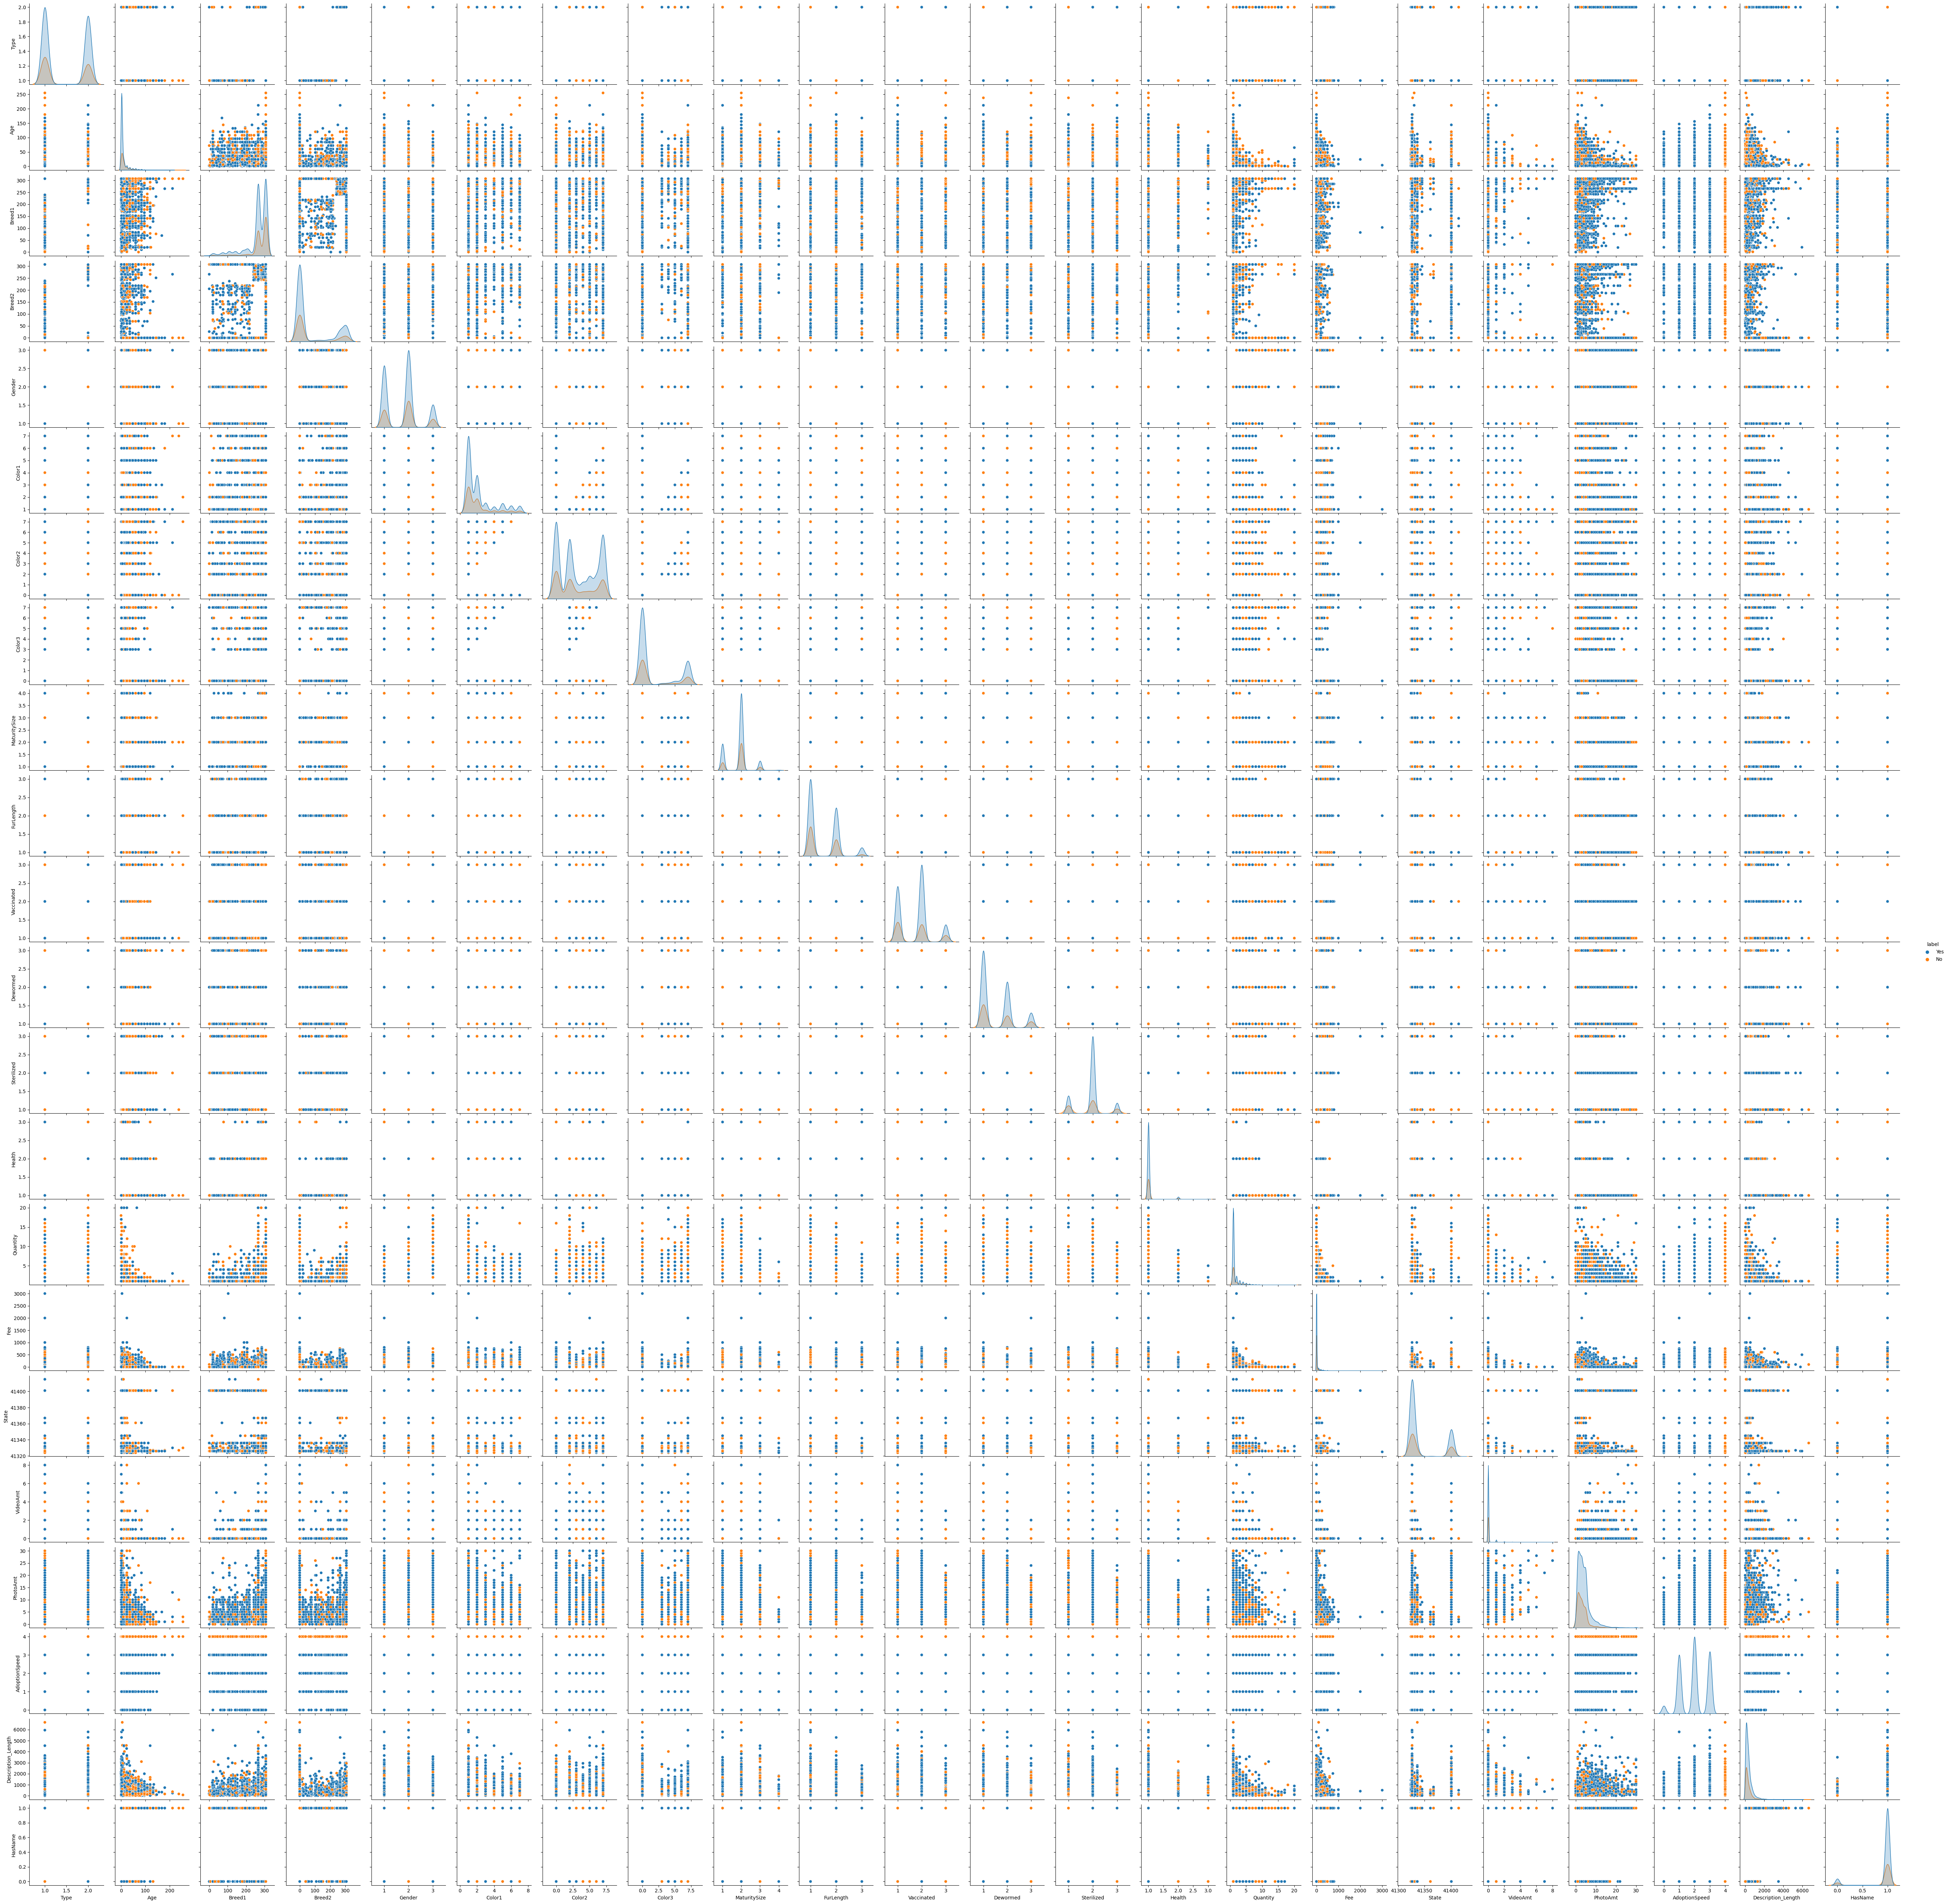

In [150]:
sns.pairplot(data=train_binary, hue = 'label')

In [155]:
y

0        Yes
1        Yes
2        Yes
3        Yes
4        Yes
        ... 
14988    Yes
14989     No
14990    Yes
14991     No
14992    Yes
Name: label, Length: 14993, dtype: object

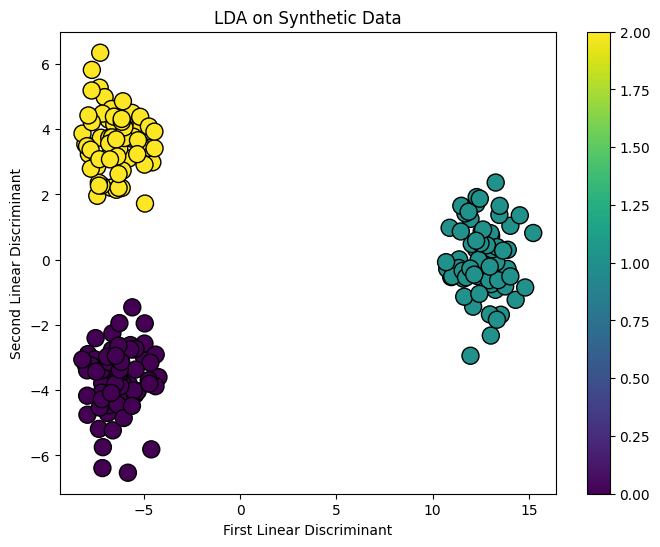

In [170]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Generate synthetic data
Xx, yy = make_blobs(n_samples=200, centers=3, n_features=3, random_state=42)

# Instantiate LDA
lda = LinearDiscriminantAnalysis(n_components=2)

# Fit and transform the data
X_lda = lda.fit_transform(Xx, yy)

# Create a scatter plot of the first two linear discriminants
plt.figure(figsize=(8, 6))
plt.scatter(X_lda[:, 0], X_lda[:, 1], c=yy, edgecolor='k', s=150)
plt.xlabel('First Linear Discriminant')
plt.ylabel('Second Linear Discriminant')
plt.title('LDA on Synthetic Data')
plt.colorbar()
plt.show()

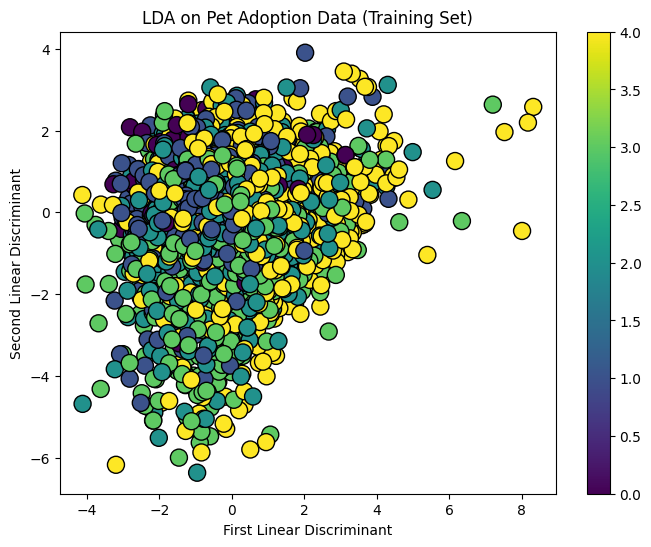

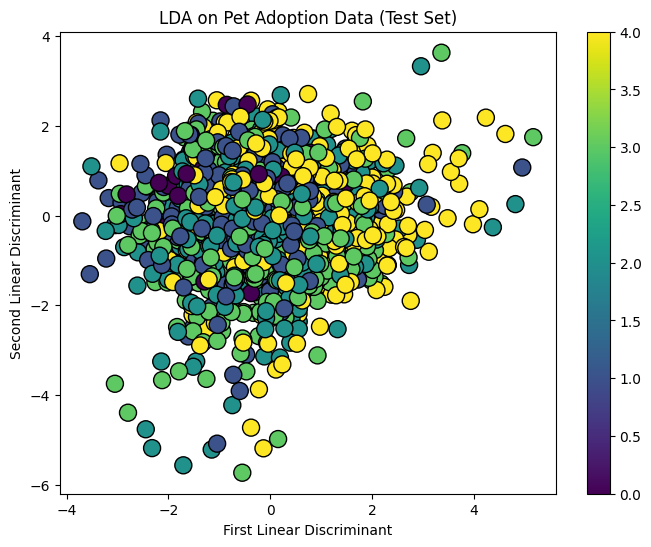

In [99]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

# cols_to_drop = ['PetID', 'AdoptionSpeed','Description','Name','RescuerID','label']
# train_binary = train.copy()
# train_binary['label'] = train_binary['AdoptionSpeed'].apply(lambda x: '0' if x == 4 else '1' if x < 4 else None)
# X = train_binary.drop(cols_to_drop,axis=1)
# y = train_binary['label']

cols_to_drop = ['PetID', 'AdoptionSpeed','Description','Name','RescuerID']
X = train.drop(cols_to_drop, axis=1)
y = train['AdoptionSpeed']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate LDA
lda = LinearDiscriminantAnalysis(n_components=3)

# Fit and transform the data using only the training set
X_lda_train = lda.fit_transform(X_train, y_train)

# Transform the test set
X_lda_test = lda.transform(X_test)

# Create a scatter plot of the first two linear discriminants for the training set
plt.figure(figsize=(8, 6))
plt.scatter(X_lda_train[:, 0], X_lda_train[:, 1], c=y_train, edgecolor='k', s=150, cmap='viridis')
plt.xlabel('First Linear Discriminant')
plt.ylabel('Second Linear Discriminant')
plt.title('LDA on Pet Adoption Data (Training Set)')
plt.colorbar()
plt.show()

# Apply the transformation to the test set and visualize
plt.figure(figsize=(8, 6))
plt.scatter(X_lda_test[:, 0], X_lda_test[:, 1], c=y_test, edgecolor='k', s=150, cmap='viridis')
plt.xlabel('First Linear Discriminant')
plt.ylabel('Second Linear Discriminant')
plt.title('LDA on Pet Adoption Data (Test Set)')
plt.colorbar()
plt.show()


<Axes: title={'center': 'LDA Coefficient Sums'}>

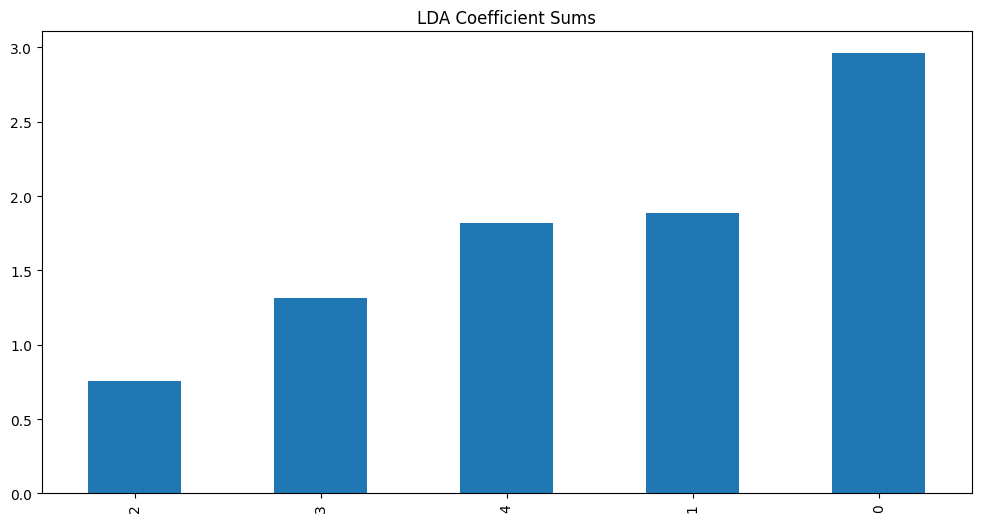

In [47]:
pd.Series(np.abs(lda.coef_).sum(axis=1), index=lda.classes_).sort_values().plot.bar(
    figsize=(12, 6), title="LDA Coefficient Sums"
)

In [179]:
lda.coef_

array([[ 4.00713143e-01, -4.37445913e-03, -4.11185030e-03,
         1.17216505e-03, -7.78700038e-02,  4.40802976e-02,
         2.30847560e-02,  4.22657099e-02, -2.31824974e-01,
         4.55245920e-01, -1.11735836e-01,  2.03222448e-01,
         1.10211852e-01,  1.77007620e-01, -7.36145899e-02,
        -6.78801297e-04,  7.09469200e-04,  1.95380577e-01,
        -3.39235407e-02, -2.04322132e-04,  2.26133250e-01],
       [ 2.70073206e-01, -9.52742913e-03, -3.72634091e-03,
        -4.25569449e-04, -9.98347911e-02,  2.94993258e-02,
        -5.12713825e-04,  2.30915559e-03, -1.16404246e-01,
         2.60352723e-01,  7.98619636e-02, -4.33501174e-02,
         2.00822191e-01, -2.35362602e-01, -3.32455472e-02,
        -3.57040892e-04, -3.40671327e-04, -1.04988106e-01,
        -1.02701203e-02,  8.90913063e-05, -2.00509938e-02],
       [-1.02350989e-02, -5.42901861e-03, -4.41835567e-04,
        -1.81249874e-04, -6.75325907e-02,  6.46382376e-03,
         2.81178488e-03,  2.22932432e-03,  1.48685905e

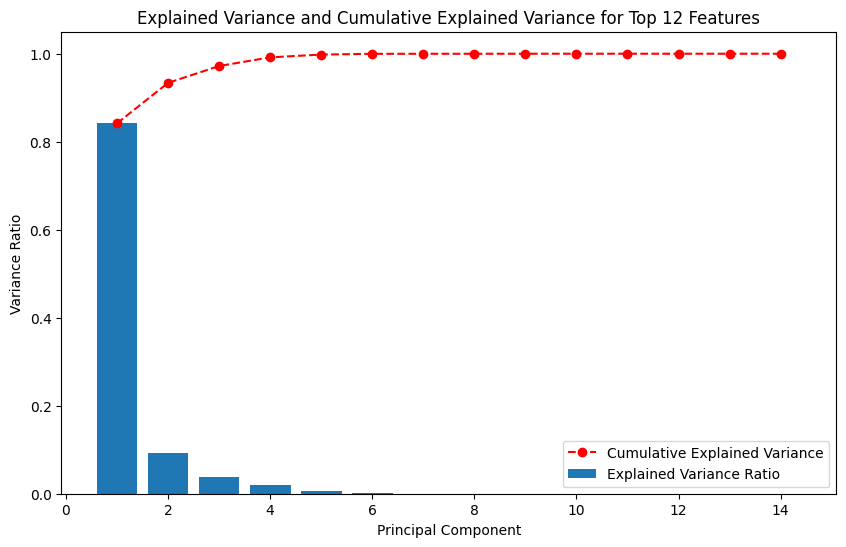

In [48]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assuming X is your feature matrix with the top 12 features
pca = PCA(n_components=14)
X_pca = pca.fit_transform(X)

# Calculate the explained variance ratio for each component
explained_var_ratio = pca.explained_variance_ratio_

# Calculate the cumulative explained variance
cumulative_explained_var = explained_var_ratio.cumsum()

cols_ = X.columns
# Plotting the explained variance and cumulative explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, 15), explained_var_ratio, label='Explained Variance Ratio')
plt.plot(range(1, 15), cumulative_explained_var, label='Cumulative Explained Variance', marker='o', linestyle='--', color='red')
plt.xlabel('Principal Component')
plt.ylabel('Variance Ratio')
plt.title('Explained Variance and Cumulative Explained Variance for Top 12 Features')
plt.legend()
plt.show()

In [206]:
pca.explained_variance_ratio_.round(2)[:10]

array([0.84, 0.09, 0.04, 0.02, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ])

IndexError: index 14 is out of bounds for axis 0 with size 14

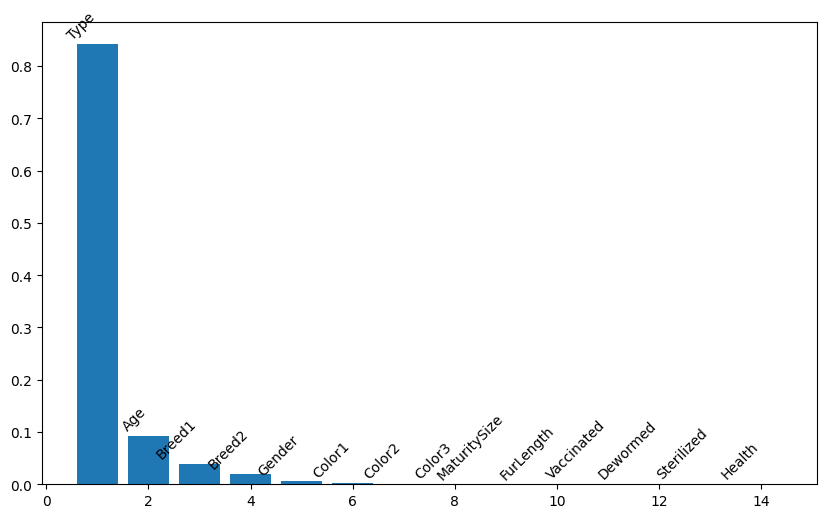

In [52]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assuming X is your feature matrix with the top 12 features
pca = PCA(n_components=14)
X_pca = pca.fit_transform(X)

# Calculate the explained variance ratio for each component
explained_var_ratio = pca.explained_variance_ratio_

# Calculate the cumulative explained variance
cumulative_explained_var = explained_var_ratio.cumsum()

cols_ = X.columns

# Plotting the explained variance and cumulative explained variance
plt.figure(figsize=(10, 6))
bar_plot = plt.bar(range(1, 15), explained_var_ratio, label='Explained Variance Ratio')

# Annotate the bars with feature names
for i, col in enumerate(cols_):
    plt.text(i + 1, explained_var_ratio[i] + 0.005, col, rotation=45, ha='right', va='bottom')

plt.plot(range(1, 15), cumulative_explained_var, label='Cumulative Explained Variance', marker='o', linestyle='--', color='red')
plt.xlabel('Principal Component')
plt.ylabel('Variance Ratio')
plt.title('Explained Variance and Cumulative Explained Variance for Top 12 Features')
plt.legend()
plt.show()


Text(0, 0.5, 'Cumulative explained variance')

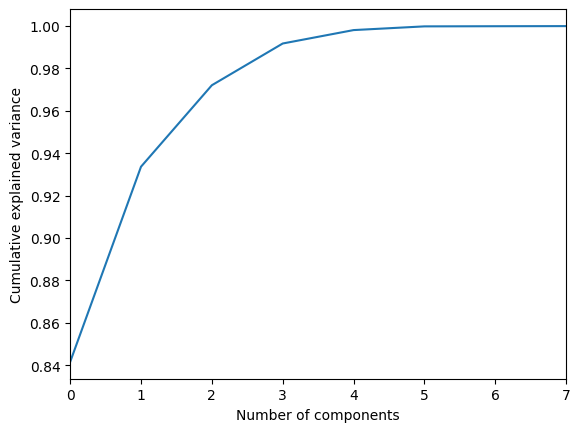

In [49]:
from sklearn.decomposition import PCA
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,7,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [217]:
np.cumsum(pca.explained_variance_ratio_)

array([0.84156076, 0.93361665, 0.97203515, 0.99171218, 0.99803796,
       0.99978748, 0.99985736, 0.99991261, 0.99995628, 0.99997237,
       0.99998457, 0.99998964, 0.99999178, 0.99999375, 0.99999545,
       0.99999677, 0.99999791, 0.99999865, 0.99999933, 0.99999977,
       1.        ])

In [51]:
X.columns

Index(['Type', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'VideoAmt',
       'PhotoAmt', 'Description_Length', 'HasName', 'polarity',
       'subjectivity'],
      dtype='object')

In [219]:
print(pca.explained_variance_ratio_.round(2)[:10])


[0.84 0.09 0.04 0.02 0.01 0.   0.   0.   0.   0.  ]
